## Summary

Created: 10/28/2017 cloned from the original part2_analysis_hatp44 (re-run).ipynb

UPDATED:

* `*_rerun.py` with longer chains (nsteps=10000) were run using prometheus pc.

In [1]:
import datetime as dt

print(dt.datetime.now())

2017-11-14 08:10:11.032395


In [2]:
!python --version

Python 3.6.1 :: Continuum Analytics, Inc.


In [3]:
import os
os.environ['CONDA_DEFAULT_ENV']

'astroconda35'

## import and parse csv

In [4]:
import glob
import pandas as pd
import matplotlib.pyplot as pl
import numpy as np
%matplotlib inline
from tqdm import tqdm

In [5]:
#styling
pl.style.use('seaborn-white')
import matplotlib
matplotlib.rcParams.update({'font.size': 18})
pl.rcParams['ytick.labelsize'] = 'large'
pl.rcParams['xtick.labelsize'] = 'large'
fontsize=18

## import lc

In [6]:
data_dir='../'

name='hatp44'
date='170215'
target_star_id='2'
comparison_star_id='13'#3
radii_range='9-14'

data={}
bands='g,r,z'.split(',')
sigma=5

for b in bands:
    fname='lcf_msct_'+b+'_'+name+'_'+date+'_t'+target_star_id+'_c'+comparison_star_id+'_r'+radii_range+'.bjd.dat'
    df=pd.read_csv(os.path.join(data_dir,fname), delimiter=' ', parse_dates=True)
    #manipulate columns
    cols = df.columns.tolist()
    cols.remove('#')
    cols.insert(-1,' ')
    df.columns = cols
    try:
        df=df.drop(['Unnamed: 21','frame', ' '],axis=1)
    except:
        pass
    df=df.set_index('BJD(TDB)-2450000')
    #df['BJD(TDB)'] = df['BJD(TDB)-2450000'].apply(lambda x: x + 2450000)
    #df=df.set_index('BJD(TDB)')
    #remove outliers
    df=df[np.abs(df-df.mean())<=(sigma*df.std())]
    data[b] = df.dropna()

In [7]:
import logging
fname = name+'_reduction.log'
logging.basicConfig(filename=fname, level=logging.INFO)

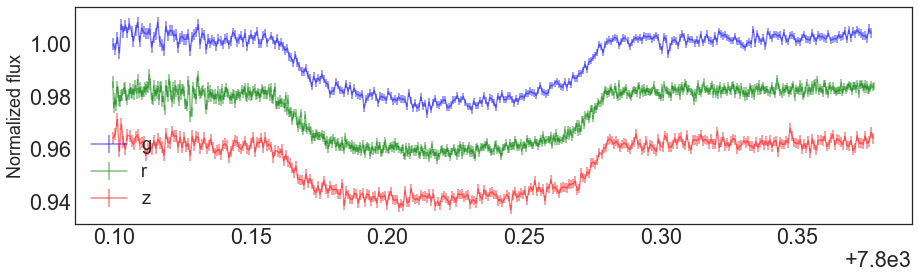

In [8]:
fluxcol =  'flux(r=11.0)'
errcol  =  'err(r=11.0)'

colors='b,g,r'.split(',')
fig,ax = pl.subplots(1,1,figsize=(15,4))

n=0
for b,c in zip(bands,colors):
    df = data[b]
    offset = n*0.02
    
    time = df.index
    flux = df[fluxcol]
    err  = df[errcol]
    
    ax.errorbar(time, flux-offset, yerr=err, label=b, color=c, alpha=0.5)
    ax.set_ylabel('Normalized flux')
    n+=1
pl.legend(loc='lower left')

In [9]:
fig.savefig('figs/raw.png')

## building the model

* See [exoplanets.org](http://exoplanets.org/detail/HAT-P-44_b) for published transit parameters

Convention:
* _P  : published value
* P_  : derived value
* P_0 : initial guess

In [10]:
tc_0  = 7.8e3+0.22
_P   = 4.301219
_t14 = 0.1302
_b   = 0.172
_a_s = 11.52
_k   = np.sqrt(0.01804)
_inc = np.deg2rad(89.10)


from astropy import units
Rp = 1.24 #Rjup
Rs = 0.949*units.Rsun.to(units.Rjup) #Rsol to Rjup
k_ = Rp/Rs

In [11]:
def scaled_a(p, t14, k, i=np.pi/2, impact_param=0):
    """
    Winn 2014 ("Transits and Occultations"), eq. 14
    """
    numer = np.sqrt( (k + 1)**2 - impact_param**2 )
    denom = np.sin(i) * np.sin(t14 * np.pi / p)
    return float(numer / denom)

def u_to_q(u1, u2):
    '''
    convert limb-darkening coefficients
    from u to q
    
    see Eq. 15 & 16 in Kipping 2013
    '''
    q1 = (u1 + u2)**2
    q2 = u1 / (2 * (u1 + u2))
    return q1, q2

def q_to_u(q1, q2):
    '''
    convert limb-darkening coefficients
    from q to u
    
    see Eq. 17 & 18 in Kipping 2013
    '''
    u1 = 2 * np.sqrt(q1) * q2
    u2 = np.sqrt(q1) * (1 - 2*q2)
    return u1, u2

from pytransit import MandelAgol

def transit_model_q(parameters, period, time, model=MandelAgol()):
    '''
    Compute flux using the Mandel-Agol model:
    
    \frac{I(\mu)}{I(1)} = 1 − u_1(1 − \mu) − u_2(1 − \mu)^2
    
    `parameters` must be a list containing:
    * k  : Rp/Rs: planet-star radius ratio
    * q1 : limb-darkening coefficient (for the linear term)
    * q2 : limb-darkening coefficient (for the quadratice term)
    * tc : transit center
    * a_s: a/Rs: scaled semi-major axis
    * b  : impact parameter
    '''
    k,q1,q2,tc,a,b = parameters
    
    #compute inclination
    inc   = np.arccos(b/a)
    #convert u to q
    u1,u2 = q_to_u(q1, q2)
    #evaluate the model
    m = model.evaluate(time, k, (u1,u2), tc, period, a, inc)
    
    return m

## Limb-darkening prior
* Limb-darkening coefficients inference from stellar parameters [Claret (2012)](https://www.aanda.org/articles/aa/pdf/2012/10/aa19849-12.pdf)

```
Uses table downloaded from:
http://vizier.u-strasbg.fr/viz-bin/VizieR-3?-source=J/A%2bA/529/A75/table-af
band must be one of: B C H I J K Kp R S1 S2 S3 S4 U V b g* i* r* u u* v y z*

log g below came from adopted model 11 (Table 11) of Hartmann+2014
```

In [12]:
import limbdark as ld

teff, uteff, logg, ulogg, feh, ufeh=5300,100, 4.460,0.06, 0.33,0.1

ldc_list     = []
ldc_err_list = []
ldp          = []

#for each band
for i in 'g*,r*,z*'.split(','):
    ldc = ld.claret(i, teff, uteff, logg, ulogg, feh, ufeh, n=int(1e4))
    ldp.append(ldc)
    
    #save in list
    #u1,u2
    ldc_list.append([ldc[0],ldc[2]]) #take first and third element of ldc 
    #uncertainties
    ldc_err_list.append([ldc[1],ldc[3]]) #take second and fourth element of ldc

## MLE

* p, period
* k, r_planet/r_star
* t14, transit duration
* i, inclination
* b, impact paramter
* tc, mid-point transit time
* u1, u2, limb-darkening coeffs
* a_scaled

In [13]:
import scipy.optimize as op

def obj(theta, p, t, f, err):
    '''
    objective function: chi-squared
    '''
    m = transit_model_q(theta, p, t)
    
    return np.sum(((f-m)/err)**2)

def rms(flux,flux_model):
    residual = flux-flux_model
    return np.sqrt(np.mean((residual)**2))

g-band
rms before: 0.0030
rms after: 0.0025

r-band
rms before: 0.0029
rms after: 0.0023

z-band
rms before: 0.0033
rms after: 0.0026



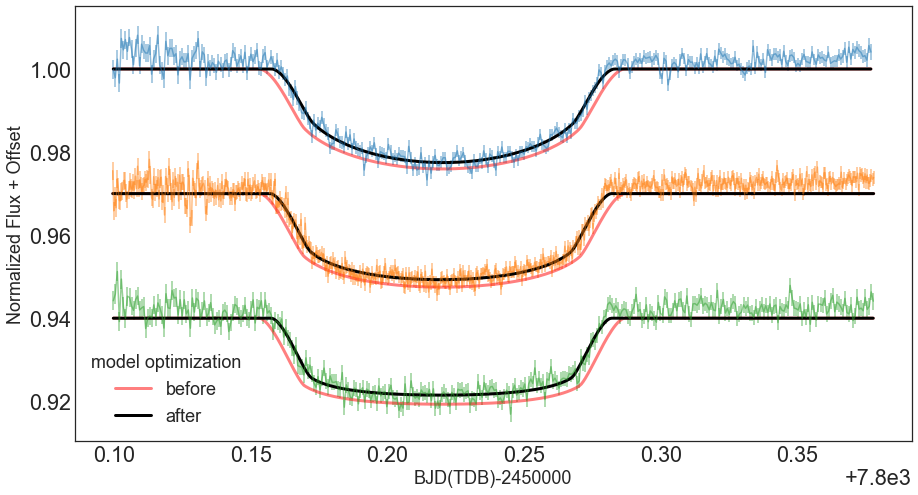

In [14]:
fig,ax = pl.subplots(1,1,figsize=(15,8))

optimized_transit_params = {} 

n=0
for b,u,c in zip(bands,ldc_list,colors):
    print('{}-band'.format(b))
    df=data[b]
    
    flux = df[fluxcol]
    time = df.index
    err  = df[errcol]
    
    #plot raw data with vertical offset
    offset = n*0.03
    pl.errorbar(time, flux-offset, yerr=err, alpha=0.5) 
    
    #compute q from u found in limbdark
    q1_,q2_ = u_to_q(u[0],u[1])

    #compute flux before optimization
    transit_params     = [k_,q1_,q2_,tc_0,_a_s,_b]
    transit_model_before  = transit_model_q(transit_params, _P, time)
    #rms before
    rms_before = rms(flux,transit_model_before)
    print('rms before: {:.4f}'.format(rms_before))
    
    #optimize parameters
    result = op.minimize(obj, transit_params,
                         args=(_P, time, flux, err), method='nelder-mead')
    
    #compute flux after optimization
    transit_params_after     = np.copy(result.x)
    transit_model_after  = transit_model_q(transit_params_after, _P, time)
    #rms after
    rms_after = rms(flux,transit_model_after)
    print('rms after: {:.4f}\n'.format(rms_after))
    
    #plot transit models
    #before (faint red)
    ax.plot(time, transit_model_before-offset, 'r-', lw=3, alpha=0.5)
    #after (black)
    ax.plot(time, transit_model_after-offset, 'k-', lw=3, alpha=1)
    ax.legend(fontsize=fontsize)
    
    #dict of optimized transit parameters to be used later
    optimized_transit_params[b] = transit_params_after
    n+=1
    
ax.set_ylabel('Normalized Flux + Offset', fontsize=fontsize)
ax.set_xlabel('BJD(TDB)-2450000', fontsize=fontsize)
ax.legend(['before','after'], title='model optimization',fontsize=fontsize)
#fig.savefig('transit_models')

In [15]:
def binning(x,y,bins):
    t=np.linspace(x[0],x[-1], bins)
    y=np.interp(x=t, xp=x, fp=y)
    return t, y

def flux_ratios(x1, y1, x2, y2, bins):
    numerator   = binning(x1,y1,bins)[1] #get y-component only
    denominator = binning(x2,y2,bins)[1]
    return numerator/ denominator

def find_2_bands(b):
    '''
    this function return the 2 bands
    other than the given band
    
    e.g. if g, return r & z
    '''
    if b=='g':
        return ['r','z']
    elif b=='r':
        return ['g','z']
    elif b=='z':
        return ['g','r']
    else:
        sys.exit(1)

In [16]:
#systematics model
def systematics_model(w, aux_vec, time):
    '''
    systematics model consists of linear combination
    of constant coefficients (computed here) 
    and auxiliary vectors:
    
    color1, color2, dx, err, vert_offset
    
    The functional form of the model is
    s = [np.sum(c[k] * x**k) for k in np.arange(N)]
    '''
    #make sure there are 4 aux. vectors
    assert len(aux_vec) == 4
    
    #unpack aux_vec
    color1, color2, dx, err = aux_vec
    #add vertical offset
    vert_offset = np.ones_like(dx)
    #construct X with time
    X = np.c_[color1, color2, dx, err, vert_offset, time]
    
    #compute systematics model
    sys_model = np.dot(X,w)
        
    return sys_model

g-band
rms (flux - transit_model): 0.0025
rms (flux/sys model - transit_model): 0.0014

rms difference: 0.0010

r-band
rms (flux - transit_model): 0.0023
rms (flux/sys model - transit_model): 0.0015

rms difference: 0.0008

z-band
rms (flux - transit_model): 0.0026
rms (flux/sys model - transit_model): 0.0013

rms difference: 0.0013



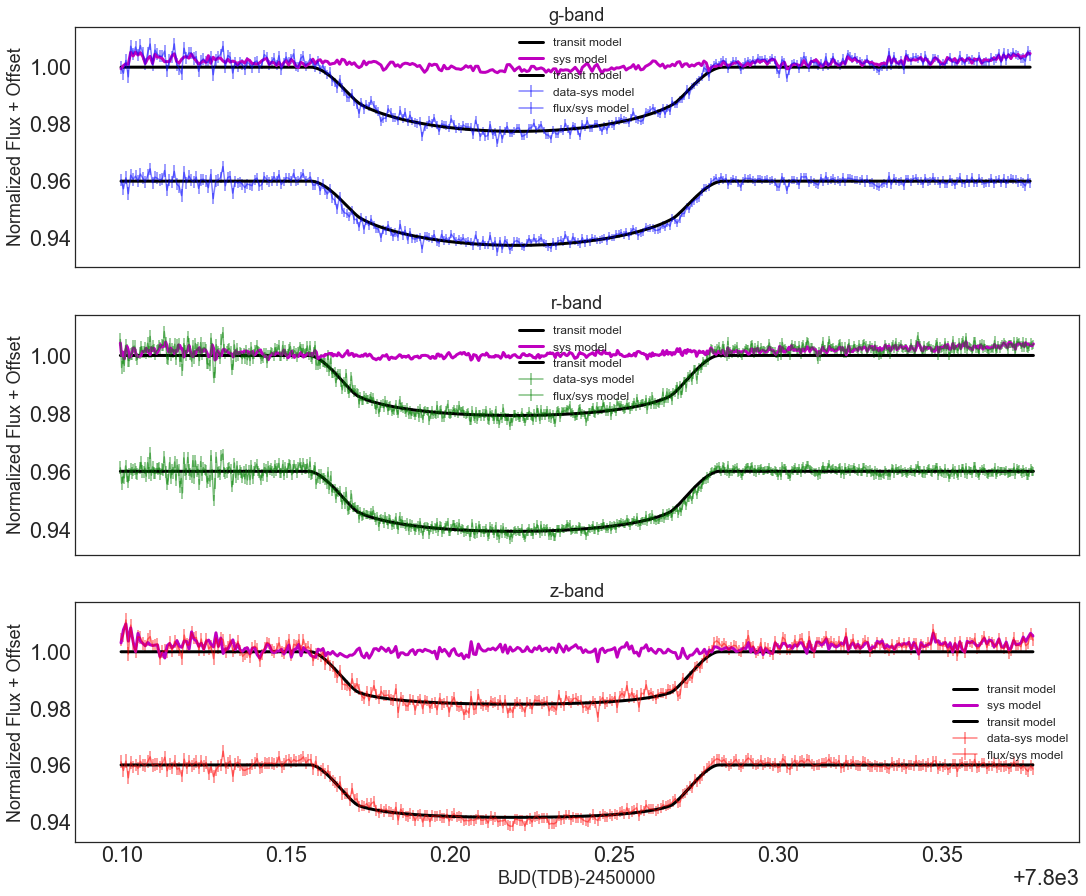

In [17]:
fig,ax = pl.subplots(3,1,figsize=(18,15), sharex=True)

X_list = {}
w_list = {}
aux_vec_list = {}

n=0
for b,u,c in zip(bands,ldc_list,colors):
    print('{}-band'.format(b))
    df=data[b]
    
    flux = df[fluxcol]
    time = df.index
    err  = df[errcol]
    
    dx   = df['dx(pix)']
    dy   = df['dy(pix)']
    airmass = df['airmass']
    #fwhm    = df['fwhm(pix)']
    #sky     = df['sky(ADU)']
    #peak    = df['peak(ADU)']
    
    #plot flux raw data
    ax[n].errorbar(time, flux, yerr=err, 
                   label='data-sys model', alpha=0.5, color=c) 
    
    transit_params = optimized_transit_params[b]
    transit_model  = transit_model_q(transit_params, _P, time)
    
    #plot best fit transit model
    ax[n].plot(time, transit_model, 'k-', lw=3, label='transit model')
    data[b]['transit_model'] = transit_model 
    
    #plot residual with offset
    sys = flux / transit_model
    data[b]['flux/transit_model'] = sys
    
    ##ax[n].plot(time, resid+0.94, 'm-', lw=3, label='residual')
    ##ax[n].plot(time, sys+0.94, 'm-', lw=3, label='residual')
       
    #determine correct band
    b1,b2 = find_2_bands(b)
    
    #compute color
    color1 = flux_ratios(time,flux,data[b1].index,
                       data[b1][fluxcol], 
                       bins=len(df))
    color2 = flux_ratios(time,flux,data[b2].index,
                       data[b2][fluxcol], 
                       bins=len(df))
    #add color to original dataframe
    data[b]['color1'] = color1
    data[b]['color2'] = color2
    
    #add vertical offset
    vert_offset = np.ones_like(dx)
    
    #construct X with time
    X = np.c_[color1, color2, dx, err, vert_offset, time]
    X_list[b] = X
    
    #compute systematics model
    w = np.linalg.solve(np.dot(X.T,X), np.dot(X.T, sys))
    w_list[b] = w
    
    #supply 4 vec, 2 others addded inside systematics_model function
    aux_vec = [color1, color2, dx, err]
    aux_vec_list[b] = aux_vec
    
    #evaluate model
    sys_model = systematics_model(w, aux_vec, time)
    
    data[b]['sys_model'] = sys_model
    
    resid = flux/sys_model - transit_model
    data[b]['residual'] = resid
    
    #compute rms
    rms_before = rms(flux, transit_model)
    #rms_after = rms(resid,sys_model)
    rms_after = rms(flux/sys_model,transit_model)
    
    print('rms (flux - transit_model): {:.4f}'.format(rms_before))
    print('rms (flux/sys model - transit_model): {:.4f}\n'.format(rms_after))
    print('rms difference: {:.4f}\n'.format(rms_before-rms_after))
    
    
    
    #plot systematics model
    ax[n].plot(time, sys_model, 'm-', lw=3, label='sys model')
    
    #plot corrected flux
    ax[n].errorbar(time, flux/sys_model-0.04, yerr=err, 
                   label='flux/sys model', alpha=0.5, color=c) 
    ax[n].plot(time, transit_model-0.04, 'k-', lw=3, label='transit model')
    
    ax[n].set_title('{}-band'.format(b), fontsize=fontsize)
    ax[n].legend(fontsize=12)
    ax[n].set_ylabel('Normalized Flux + Offset', fontsize=fontsize)
    n+=1
    
pl.xlabel('BJD(TDB)-2450000', fontsize=fontsize)
#fig.savefig('systematics_model')

In [18]:
fig.savefig('figs/model-MLE.png')

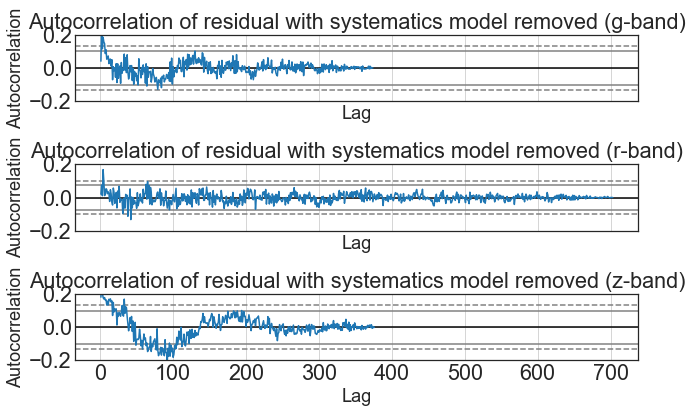

In [19]:
fig, ax = pl.subplots(nrows=3,ncols=1,figsize=(10,6), sharex=True)

n=0
for b in bands:
    df   = data[b]
    time = df.index
    
    #get residual computed earlier    
    resid_wo_sys = data[b]['residual']
        
    pd.plotting.autocorrelation_plot(resid_wo_sys, ax=ax[n])
    ax[n].set_title('Autocorrelation of residual with systematics model removed ({}-band)'.format(b))
    ax[n].set_ylim(-0.2,0.2)
    n+=1
fig.tight_layout()
#fig.savefig('autocorrelation.png')

In [20]:
fig.savefig('figs/autocorrelation.png')

In [21]:
def loglike(params_full, p, t, f, err, aux_vec, 
            ret_mod=False, ret_sys=False, ret_full = False):
    '''
    * computes the log likelihood given the optimized transit and model parameters
    * either or both transit and systematics models can also be returned
    '''
    
    m = transit_model_q(params_full[:6], p, t)
    
    #color1,color2,dx,err = aux_vec
    s = systematics_model(params_full[6:], aux_vec, t) # #add sys model
    
    if ret_mod:
        return m
    if ret_sys:
        return s
    if ret_full:
        return m*s
    
    resid = f / s - m
    
    #-0.5*(np.sum((resid)**2 * np.exp(-2*ls) + 2*ls))
    C = np.log(2*np.pi)
    
    return -0.5*(np.sum(np.log(err) + C + (resid/err)**2))

#negative log-likelihood
nll = lambda *x: -loglike(*x)

--g--
NLL before: -719.0697500606567
NLL after: -738.0879783100229
--r--
NLL before: -1332.2851800129806
NLL after: -1349.6960345110774
--z--
NLL before: -752.6472253206457
NLL after: -758.3912235798784


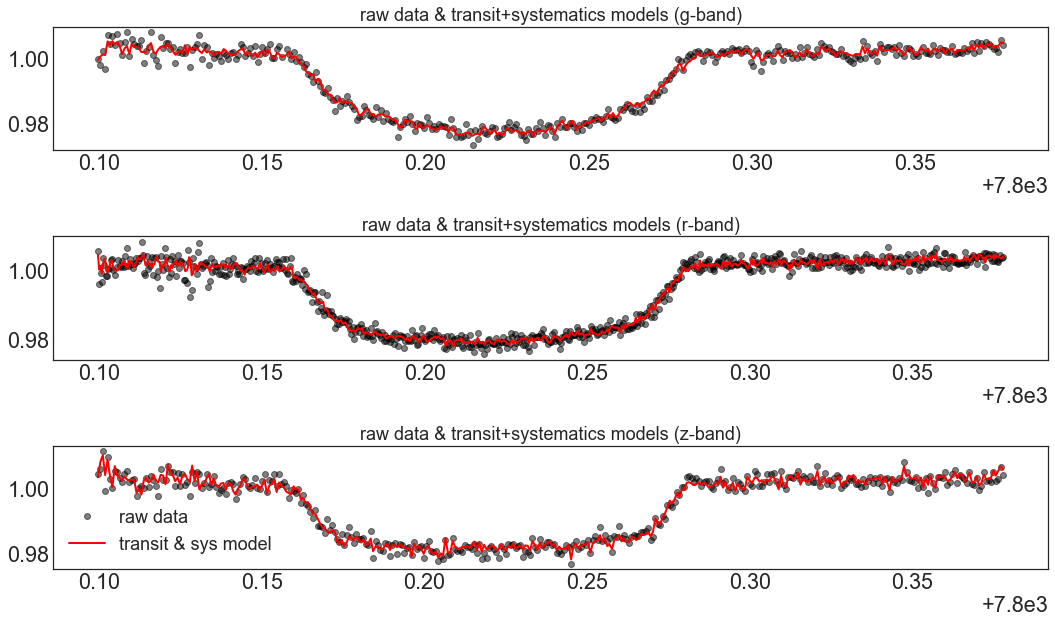

In [22]:
#parameters vector: 6 transit, 4+2 systematics

import scipy.optimize as op
fig = pl.figure(figsize=(15,9))

save_model = True

n=0
for b in bands:
    df=data[b]

    flux = df[fluxcol]
    time = df.index

    #sys mod params
    airmass   = df['airmass']
    err       = df['err(r=11.0)']
    dx        = df['dx(pix)']
    #dy        = df['dy(pix)']
    print('--{}--'.format(b))
    
    #transit params computed before
    transit_params = optimized_transit_params[b]
    
    #weights computed before
    w = w_list[b]
    
    #aux_vec saved before
    aux_vec = aux_vec_list[b]
    
    #combine optimized transit params and sys params
    full_params = np.concatenate((transit_params, w), axis=0)
    
    #compute nll
    print ("NLL before: {}".format(nll(full_params, 
                                       _P, 
                                       time, 
                                       flux, 
                                       err, 
                                       aux_vec)))
    #MLE optimization of transit+sys parameters
    result = op.minimize(nll, full_params,    
                         args=(_P, time, flux, err, aux_vec),
                         method='nelder-mead')
    
    #result of optimization
    print ("NLL after: {}".format(nll(result.x,   
                                      _P, 
                                      time, 
                                      flux, 
                                      err, 
                                      aux_vec)))
    
    #compute models
    full_model    = loglike(result.x, _P, time, flux, err, aux_vec, 
                            ret_full=True)
    transit_model = loglike(result.x, _P, time, flux, err, aux_vec, 
                     ret_mod=True)
    sys_model     = loglike(result.x, _P, time, flux, err, aux_vec, 
                     ret_sys=True)
    
    resid = flux/sys_model - transit_model
    
    if save_model:
        data[b]['transit_model'] = transit_model
        data[b]['sys_model']     = sys_model
        data[b]['full_model']    = full_model
        data[b]['residual']      = resid
    
    rms   = np.sqrt(np.mean(resid**2))
    
    ax = pl.subplot(3,1,n+1)
    #plot corrected data
    ax.plot(time, flux, 'ko', alpha=0.5, label='raw data')
    ax.set_title('raw data & transit+systematics models ({}-band)'.format(b), fontsize=fontsize)
    #plot transit+sys models
    ax.plot(time, full_model, 'r-', lw=2, label='transit & sys model');
    n+=1
    
pl.legend(fontsize=fontsize)
fig.tight_layout()
fig.savefig('full model.png')

In [23]:
import numpy as np
from uncertainties import ufloat 
from astropy import units as u

P   = ufloat(4.301219,0.000019)
Rp  = ufloat(1.523,0.442)   #+0.442-0.226

Rs_jup  = 0.949*u.Rsun.to(u.Rjup)
Rs_jup_u= 0.08*u.Rsun.to(u.Rjup) #+0.08/-0.037
Rs  = ufloat(Rs_jup,Rs_jup_u)

t14 = ufloat(0.1302,0.0008) 
b   = ufloat(0.172,0.079)   #+0.079/-0.074     
a_s = ufloat(11.52,0.74)
k   = ufloat(np.sqrt(0.01804),np.sqrt(0.00027)) 
inc = ufloat(np.deg2rad(89.10),np.deg2rad(0.4))

In [24]:
def tshape_approx(a, k, b):
    """
    Seager & Mallen-Ornelas 2003, eq. 15
    """
    i = np.arccos(b/a)
    alpha = (1 - k)**2 - b**2
    beta = (1 + k)**2 - b**2
    return np.sqrt( alpha / beta )


def max_k(tshape):
    """
    Seager & Mallen-Ornelas 2003, eq. 21
    """
    return (1 - tshape) / (1 + tshape)

from astropy import units
from astropy import constants

def rhostar(p, a):
    """
    Eq.4 of Kipping 2014. 
    Assumes circular orbit & Mp<<Ms
    
    http://arxiv.org/pdf/1311.1170v3.pdf
    
    c.f. Seager & __ 2002
    """
    p = p * units.d
    gpcc = units.g / units.cm ** 3
    rho_mks = 3 * np.pi / constants.G / p ** 2 * a ** 3
    return rho_mks.to(gpcc).value

In [25]:
from scipy import stats
def logprior(full_params,u_prior=None):
    '''
    full_paras: transit+systematic model parameters
    up: limb-darkening prior for u1,u2
    '''
    #unpack transit parameters
    k,q1,q2,tc,a_s,impact_param = full_params[:6]
    inc=np.arccos(impact_param/a_s)
    
    tshape = tshape_approx(a_s, k_, _b)
    kmax = max_k(tshape)
    
    rho_s = rhostar(_P, a_s)

    #Uniform priors: return log 0= inf if outside interval
    if  q1  < 0 or q1 > 1 or \
        q2  < 0 or q2 > 1 or \
        k   < 0 or k  > kmax or \
        impact_param   < 0 or impact_param  > 1 or \
        inc > np.pi/2     or \
        a_s < 0 or a_s  > 13 or \
        rho_s < 1 or rho_s > 10 or \
        tc < tc_0-_t14/2 or tc > tc_0+_t14:
        
        #print('off limits encountered in logprior')
        return -np.inf
    
    #if they are inside interval, add log 1 = 0 to logprior
    
    #logprior
    lp = 0
    
    #Normal priors on q1,q2 with sigma=uncertainty from Claret+2012
    u1,u2 = q_to_u(q1,q2)
    
    if u_prior is not None:
        #evaluate log of N(u,sigma)
        sigma1=u_prior[1]
        sigma2=u_prior[3]
        #add to logprior
        lp += np.log(stats.norm.pdf(u1, loc=u_prior[0], scale=sigma1))
        lp += np.log(stats.norm.pdf(u2, loc=u_prior[2], scale=sigma2))
    
    #what are our priors for systematics model parameters?
    
    return lp

In [26]:
def logprob(full_params,
            time_list,
            flux_list,
            period,
            color1_list,
            color2_list,
            dx_list,
            err_list,
            ldc_prior=None):
    
    t1,t2,t3                   = time_list
    f1,f2,f3                   = flux_list
    color1g,color1r,color1z    = color1_list
    color2g,color2r,color2z    = color2_list
    dx1,dx2,dx3                = dx_list
    err1,err2,err3             = err_list
    #airmass1,airmass2,airmass3 = airmass_list
    #ycen1,ycen2,ycen3         = dy_list
    
    #unpack full params for 3 bands
    k_g,k_r,k_z,tc,a,impact_param,q1g,q2g,q1r,q2r,q1z,q2z,\
    w0g,w1g,w2g,w3g,w4g,w5g,\
    w0r,w1r,w2r,w3r,w4r,w5r,\
    w0z,w1z,w2z,w3z,w4z,w5z = full_params
    
    #set up params list for each band
    theta1 = [k_g,q1g,q2g,tc,a,impact_param,w0g,w1g,w2g,w3g,w4g,w5g]
    theta2 = [k_r,q1r,q2r,tc,a,impact_param,w0r,w1r,w2r,w3r,w4r,w5r]
    theta3 = [k_z,q1z,q2z,tc,a,impact_param,w0z,w1z,w2z,w3z,w4z,w5z]
    
    #set up auxiliary vector for each band
    aux_vec1 = color1g, color2g, dx1, err1
    aux_vec2 = color1r, color2r, dx2, err2
    aux_vec3 = color1z, color2z, dx3, err3
    
    #sum loglike for each band
    ll  = loglike(theta1, period, t1, f1, err1, aux_vec1)
    ll += loglike(theta2, period, t2, f2, err2, aux_vec2)
    ll += loglike(theta3, period, t3, f3, err3, aux_vec3)
    
    if ldc_prior is not None:
        lp  = logprior(theta1, u_prior=ldc_prior[0])
        lp += logprior(theta2, u_prior=ldc_prior[1])
        lp += logprior(theta3, u_prior=ldc_prior[2])
    else:
        #no ldc prior (if stellar parameters not known)
        lp  = logprior(theta1)
        lp += logprior(theta2)
        lp += logprior(theta3)
    
    if np.isnan(ll).any():
        #print('NaN encountered in loglike')
        return -np.inf
    
    #total: sum of prior and likelihood
    return lp + ll

#negative log prob
nlp = lambda *x: -logprob(*x)

In [27]:
#ignore tc, a_s, b
k_g,q1g,q2g,_,_,_ = optimized_transit_params['g']
k_r,q1r,q2r,_,_,_ = optimized_transit_params['r']
k_z,q1z,q2z,_,_,_ = optimized_transit_params['z']

times    = []
fluxes   = []
colors1  = []
colors2  = []
errs     = []
dxs      = []
#dys      =[]
#airmasses= []

for b in bands:
    #sys mod params
    df = data[b]
    times.append(df.index)
    fluxes.append(df['flux(r=11.0)'])
    colors1.append(df['color1'])
    colors2.append(df['color2'])
    errs.append(df['err(r=11.0)'])    
    dxs.append(df['dx(pix)'])    
    
color1_coeffs= []
color2_coeffs= []
dx_coeffs    = []
err_coeffs   = []
vert_offsets = []
time_coeffs  = []

for b in bands:
    color1_coeffs.append(w_list[b][0])
    color2_coeffs.append(w_list[b][1])
    dx_coeffs.append(w_list[b][2])
    err_coeffs.append(w_list[b][3])
    vert_offsets.append(w_list[b][4])
    time_coeffs.append(w_list[b][5])
    
#unpack
w0g,w0r,w0z = color1_coeffs
w1g,w1r,w1z = color2_coeffs
w2g,w2r,w2z = dx_coeffs
w3g,w3r,w3z = err_coeffs
w4g,w4r,w4z = vert_offsets
w5g,w5r,w5z = time_coeffs

full_params = [k_g,k_r,k_z,tc_0,_a_s,_b,q1g,q2g,q1r,q2r,q1z,q2z,\
                w0g,w1g,w2g,w3g,w4g,w5g,\
                w0r,w1r,w2r,w3r,w4r,w5r,\
                w0z,w1z,w2z,w3z,w4z,w5z]



In [28]:
logprob(full_params,
        times,
        fluxes,
        _P,
        colors1,
        colors2,
        dxs,
        errs,
        ldc_prior=ldp)

2554.7756269502243

In [29]:
def binned(a, binsize, fun=np.mean):
    a_b = []
    for i in range(0, a.shape[0], binsize):
        a_b.append(fun(a[i:i+binsize], axis=0))
        
    return np.array(a_b)

def binned_rms(residuals, timestep, start_min=5, stop_min=20):
    """
    residuals : flux/sys_model - transit_model
    timestep  : time interval between datapoints in seconds
    """

    assert timestep < start_min * 60
    ndata = len(residuals)

    min_bs = int(start_min * 60 / timestep)
    max_bs = int(stop_min  * 60 / timestep)

    rms_err      = []
    rms_err_dict = {}
    for bs in np.arange(min_bs, max_bs + 1):
        nbins = ndata / bs
                
        #binning       
        rms_val = np.sqrt(np.mean(binned(residuals,bs)**2))
        rms_err.append(rms_val)
        rms_err_dict[bs] = rms_val
        
    return rms_err_dict

In [30]:
def chisq(resid, sig, ndata=None, nparams=None, reduced=False):
    if reduced:
        assert ndata is not None and nparams is not None
        dof = ndata - nparams
        return np.sqrt(sum((resid / sig)**2)/ (dof))
    else:
        return sum((resid / sig)**2)

In [31]:
reduced_chi2 = {}

newerrcols = []

for b in bands:
    print('{}-band'.format(b))
    df = data[b]
    
    ndata = len(df)
    nparams = len(full_params)
    
    resid = df['residual']
    err   = df['err(r=11.0)']
    
    chi2 = chisq(resid, err, ndata, nparams)
    red_chi2 = chisq(resid, err, ndata, nparams, reduced=True)
    
    #save
    reduced_chi2[b] = red_chi2
    col='err(r=11.0)*{:.2f}'.format(red_chi2)
    newerrcols.append(col)
    data[b][col] = err*red_chi2
    
    print('chi2 ={:.2f}'.format(chi2))
    print('reduced chi2 ={:.4f}'.format(red_chi2))

g-band
chi2 =260.70
reduced chi2 =0.8705
r-band
chi2 =579.69
reduced chi2 =0.9281
z-band
chi2 =149.29
reduced chi2 =0.6569


In [32]:
def binned(a, binsize, fun=np.mean):
    a_b = []
    for i in range(0, a.shape[0], binsize):
        a_b.append(fun(a[i:i+binsize], axis=0))
        
    return a_b

def beta(residuals, timestep, start_min=5, stop_min=20, return_dict=False):
    """
    residuals : flux/sys_model - transit_model
    timestep  : time interval between datapoints in seconds
    
    Final beta is computed by taking the median of the betas:
                np.nanmedian(betas)
    """

    assert timestep < start_min * 60
    ndata = len(residuals)
    
    sigma1 = np.std(residuals)

    min_bs = int(start_min * 60 / timestep)
    max_bs = int(stop_min  * 60 / timestep)

    betas      = []
    betas_dict = {}
    for bs in np.arange(min_bs, max_bs + 1):
        nbins = ndata / bs
        sigmaN_theory = sigma1 / np.sqrt(bs) * np.sqrt( nbins / (nbins - 1) )
        
        #binning
        sigmaN_actual = np.std(binned(residuals,bs))
        beta = sigmaN_actual / sigmaN_theory
        
        betas_dict[bs] = beta
        betas.append(beta)
        
    if return_dict:
        return betas_dict
    else:
        return np.nanmedian(betas)

In [33]:
beta_factor_list = {}

exptimes = [60,30,60] #sec

for b,col,ts in zip(bands,newerrcols,exptimes):
    df = data[b]
    resid = df['residual'].values
    
    beta_fac = beta(resid, ts, start_min=5, stop_min=20, return_dict=True)
    beta_factor_list[b]= beta_fac

In [34]:
beta_factor = {}

exptimes = [60,30,60] #sec

for b,col,ts in zip(bands,newerrcols,exptimes):
    df = data[b]
    resid = df['residual'].values
    
    beta_fac = beta(resid, ts, start_min=5, stop_min=20)
    beta_factor[b]= beta_fac
    
    err = df[col]
    
    #inflate error once more (after rescaling red. chi-squared)
    inflated_err = err * beta_fac
    
    #add to df 
    data[b]['err_inflated'] = inflated_err
    
    print('beta factor ={:.4f}'.format(beta_fac))

beta factor =1.1013
beta factor =1.1216
beta factor =1.5933


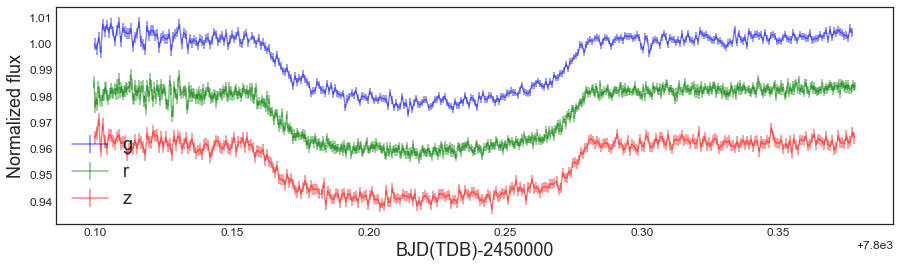

In [35]:
import matplotlib.pyplot as pl
%matplotlib inline

fluxcol =  'flux(r=11.0)'
errcol  =  'err_inflated' #'err(r=11.0)'

colors='b,g,r'.split(',')
fig,ax = pl.subplots(1,1,figsize=(15,4))

n=0
for b,c in zip(bands,colors):
    df = data[b]
    offset = n*0.02
    
    time = df.index
    flux = df[fluxcol]
    err  = df[errcol]
    
    ax.errorbar(time, flux-offset, yerr=err, label=b, color=c, alpha=0.5)
    ax.set_ylabel('Normalized flux', fontsize=fontsize)
    n+=1
pl.legend(loc='lower left', fontsize=fontsize)
pl.xlabel('BJD(TDB)-2450000', fontsize=fontsize)
#fig.savefig('inflated errors.png')

In [36]:
errs=[]
for b in bands:
    df=data[b]
    errs.append(df['err_inflated'])  

## MCMC

Note the [difference](https://stats.stackexchange.com/questions/74082/what-is-the-difference-in-bayesian-estimate-and-maximum-likelihood-estimate) in interpretation of their results.

## Run mcmc

## Initial results: Parameter best estimates (including burn-in)

In [37]:
#new results
import gzip
loc='.'

with gzip.GzipFile(os.path.join(loc,'chain1.npy.gz'), "r") as g:
    chain=np.load(g)
chain.shape

(240, 1000, 30)

In [38]:
param_names='k_g,k_r,k_z,tc,a,b,q1g,q2g,q1r,q2r,q1z,q2z,w0g,w1g,w2g,w3g,w4g,w5g,w0r,w1r,w2r,w3r,w4r,w5r,w0z,w1z,w2z,w3z,w4z,w5z'.split(',')

## excluding burn-in

In [39]:
import gzip
loc='.'

with gzip.GzipFile(os.path.join(loc,'chain2.npy.gz'), "r") as g:
    chain2=np.load(g)

nwalkers, nsteps, ndim = chain2.shape
nwalkers, nsteps, ndim

(240, 10000, 30)

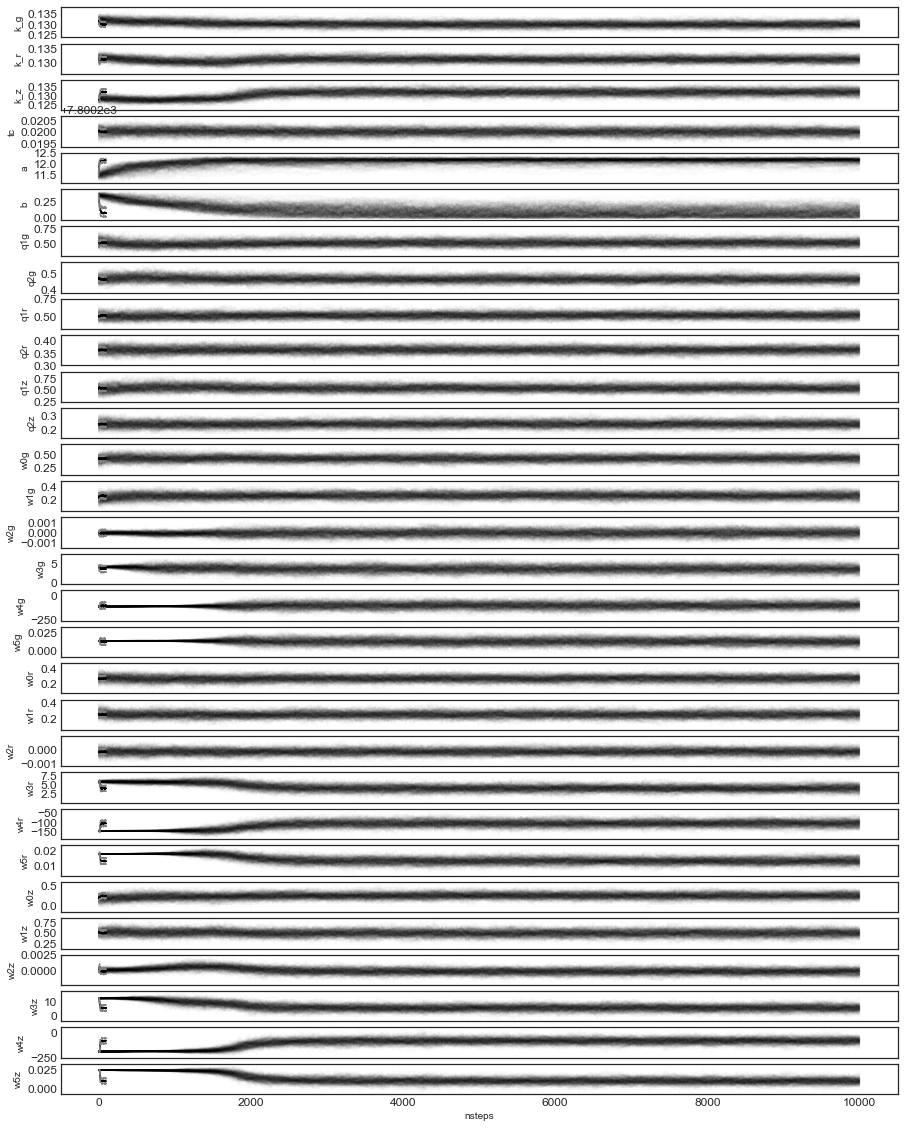

In [40]:
pl.style.use('seaborn-white')

thin = 100

fig, axs = pl.subplots(ndim, 1, figsize=(15,ndim/1.5), sharex=True)
ls, lc = ['-','--','--'], ['k', '0.5', '0.5']
percs = [np.percentile(chain2[:,::thin,i], [50,16,84], 0) for i in range(ndim)]
[axs.flat[i].plot(c, drawstyle='steps', color='k', alpha=4./nwalkers) for i,c in enumerate(chain2.T)]
[[axs.flat[i].plot(percs[i][j], c=lc[j], ls=ls[j]) for j in range(3)] for i in range(ndim)]
[axs.flat[i].set_ylabel(l) for i,l in enumerate(param_names)]
    
pl.xlabel('nsteps')

In [41]:
def gelman_rubin(chains, verbose=False):
    assert chains.ndim == 3
    nn = chains.shape[1]
    mean_j = chains.mean(axis=1)
    var_j = chains.var(axis=1)
    B = nn * mean_j.var(axis=0)
    W = var_j.mean(axis=0)
    R2 = ( W*(nn-1)/nn + B/nn ) / W
    return np.sqrt(R2)

In [42]:
gr = gelman_rubin(chain)

n=0
for stat in gr:
    if stat > 1.05:
        print('{}\t{:.2f}'.format(param_names[n],stat))
        n+=1

k_g	1.08
k_r	1.06
k_z	1.07
tc	1.08
a	1.09
b	1.08
q1g	1.09
q2g	1.08
q1r	1.08
q2r	1.06
q1z	1.07
q2z	1.08
w0g	1.11
w1g	1.13
w2g	1.09
w3g	1.10
w4g	1.10


In [43]:
fig.savefig('figs/chain2.png')

In [44]:
burn=9000
fc = chain2[:,burn:,:].reshape([-1,chain2.shape[-1]])
fc.shape

(240000, 30)

In [45]:
del chain2

In [46]:
#load
with gzip.GzipFile(os.path.join(loc,'lnp2.npy.gz'), "r") as g:
    lnp2=np.load(g)
lnp2.shape

(2400000,)

In [47]:
#remove burnin
lnp2=lnp2[nwalkers*burn:]
lnp2.shape

(240000,)

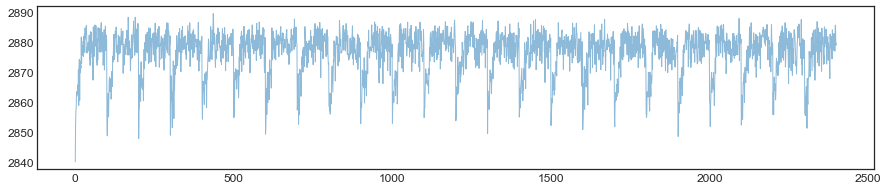

In [49]:
thin=100

fig=pl.figure(figsize=(15,3))
pl.plot(lnp2[::thin], lw=1, alpha=0.5)

## Results

Compare the above results to previous [published results](http://exoplanet.eu/catalog/HAT-P-44_b/).

In [50]:
#using full chain excluding burn-in
max_idx=np.argmax(lnp2) #fc_lnprob

#posterior of parameter vector
pv=fc[max_idx,:]

for n, i in zip(param_names, pv): 
    print('{0}: {1:.4f}'.format(n,i))

k_g: 0.1288
k_r: 0.1307
k_z: 0.1307
tc: 7800.2200
a: 12.1310
b: 0.0868
q1g: 0.5970
q2g: 0.4585
q1r: 0.5867
q2r: 0.3533
q1z: 0.5972
q2z: 0.2213
w0g: 0.4515
w1g: 0.2567
w2g: -0.0001
w3g: 4.5204
w4g: -124.3324
w5g: 0.0160
w0r: 0.3091
w1r: 0.2666
w2r: -0.0003
w3r: 3.4863
w4r: -82.7407
w5r: 0.0107
w0z: 0.3216
w1z: 0.5414
w2z: 0.0005
w3z: 6.4826
w4z: -103.9331
w5z: 0.0133


In [51]:
final_theta=np.copy(pv)

In [52]:
np.save('theta_post.csv',final_theta)

In [159]:
pd.set_option('display.precision',4)
df = pd.DataFrame(data=fc.copy(), columns=param_names)
df.describe()

k_g          k_r          k_z           tc            a  \
count  240000.0000  240000.0000  240000.0000  240000.0000  240000.0000   
mean        0.1302       0.1311       0.1323    7800.2200      12.1543   
std         0.0012       0.0010       0.0016       0.0001       0.1039   
min         0.1246       0.1272       0.1260    7800.2195      11.5555   
25%         0.1294       0.1305       0.1313    7800.2199      12.1153   
50%         0.1302       0.1311       0.1323    7800.2200      12.1782   
75%         0.1310       0.1317       0.1334    7800.2201      12.2208   
max         0.1353       0.1349       0.1381    7800.2206      12.3814   

                b          q1g          q2g          q1r          q2r  \
count  2.4000e+05  240000.0000  240000.0000  240000.0000  240000.0000   
mean   9.3661e-02       0.5220       0.4675       0.5196       0.3645   
std    6.5808e-02       0.0454       0.0188       0.0381       0.0121   
min    2.3357e-06       0.3413       0.4000       0.3696       0.3130   
25%    4.0306e-02       0.4918       0.4551       0.4940       0.3564   
50%    8.3247e-02       0.5213       0.4671       0.5199       0.3647   
75%    1.3378e-01       0.5518       0.4798       0.5456       0.3725   
max    3.3868e-01       0.7266       0.5508       0.6721       0.4123   

          ...              w2r          w3r          w4r          w5r  \
count     ...       2.4000e+05  240000.0000  240000.0000  240000.0000   
mean      ...      -1.5166e-04       4.1031    -104.0637       0.0134   
std       ...       1.9651e-04       0.7512      15.1225       0.0019   
min       ...      -9.0390e-04       1.2758    -166.7254       0.0056   
25%       ...      -2.8567e-04       3.5958    -113.9431       0.0121   
50%       ...      -1.5256e-04       4.0939    -103.7585       0.0134   
75%       ...      -1.9758e-05       4.5891     -94.0102       0.0147   
max       ...       5.8336e-04       7.3804     -43.1143       0.0214   

               w0z          w1z         w2z          w3z          w4z  \
count  240000.0000  240000.0000  2.4000e+05  240000.0000  240000.0000   
mean        0.2594       0.5052 -6.6511e-05       5.3789     -82.4819   
std         0.0647       0.0724  3.8689e-04       1.9295      25.9175   
min        -0.0225       0.2143 -1.5616e-03      -2.3793    -201.8598   
25%         0.2161       0.4574 -3.2205e-04       4.0638     -99.8858   
50%         0.2591       0.5064 -5.8326e-05       5.3782     -82.9247   
75%         0.3031       0.5541  1.9172e-04       6.7156     -64.7815   
max         0.5231       0.8273  1.5174e-03      13.3811      37.0267   

               w5z  
count  240000.0000  
mean        0.0106  
std         0.0033  
min        -0.0047  
25%         0.0083  
50%         0.0107  
75%         0.0128  
max         0.0259  

[8 rows x 30 columns]

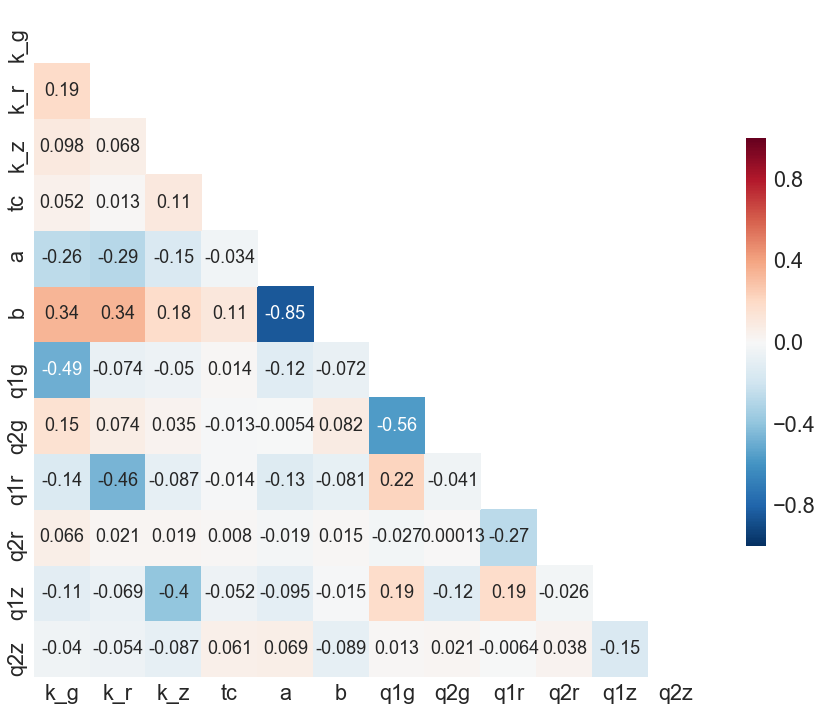

In [161]:
import seaborn as sb
sb.set_style('white')

fig = pl.figure(figsize=(15,15))

n=-18
cols = df.columns[:n]
corr = df[cols].corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sb.heatmap(corr, mask=mask, annot=True, square=True, cbar_kws={"shrink": .5})

In [162]:
fig.savefig('correlation matrix.png')

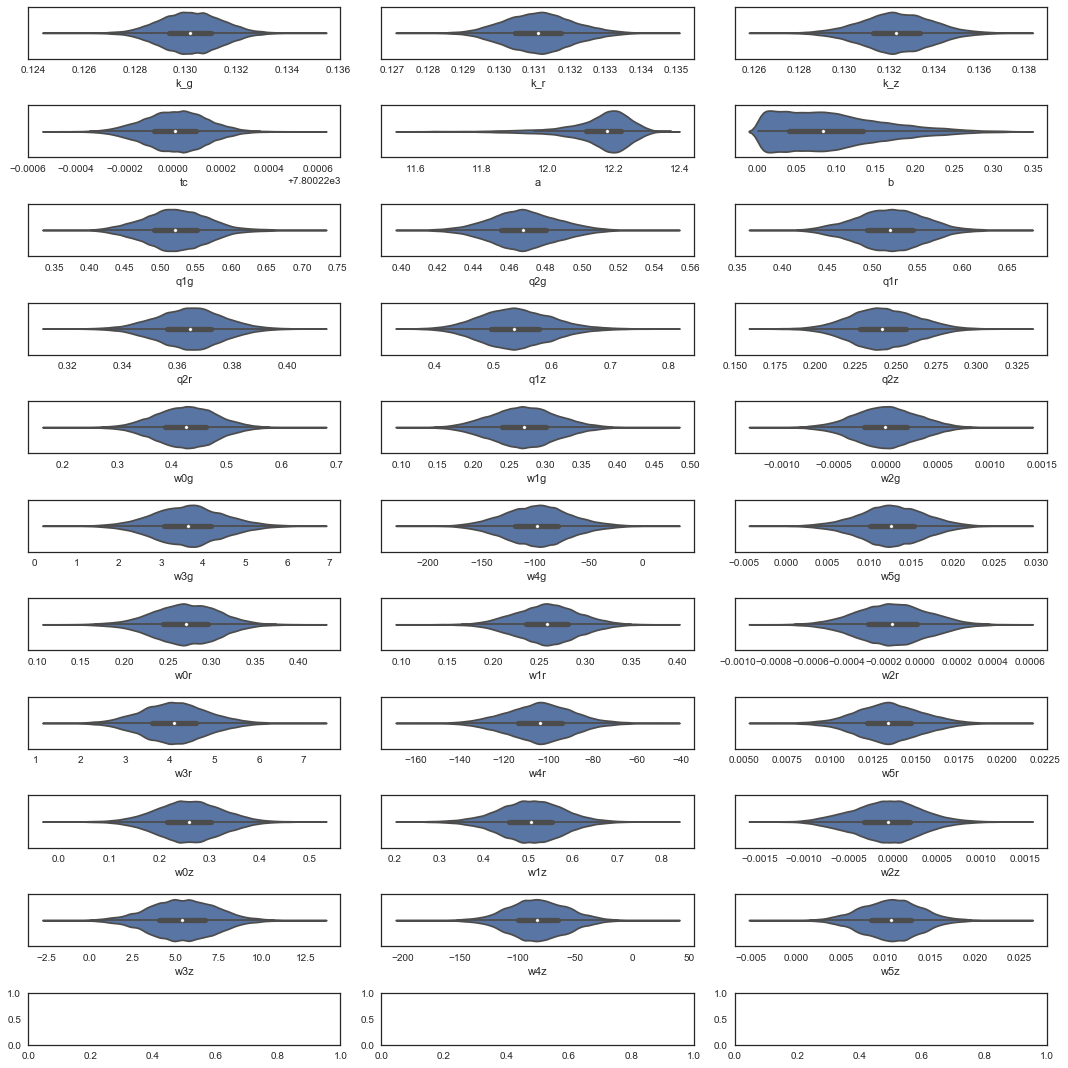

In [54]:
import seaborn as sb

with sb.axes_style('white'):
    fig, axs = pl.subplots(11,3, figsize=(15,15))
    [sb.violinplot(df[p], ax=axs.flat[i]) for i,p in enumerate(param_names)]
    #[axs.flat[i].text(0.05,0.9, p, transform=axs.flat[i].transAxes) for i,p in enumerate(param_names)]
    pl.setp(axs, ylabel='')
    fig.tight_layout()

In [55]:
fig.savefig('figs/params_aposteriori_distributions.png')

## Sample the flatchain

In [56]:
#100 samples from the posterior for each band 
mod_sys={}
sys={}
mod={}

col1=[0,6,7,3,4,5,12,13,14,15,16,17]
col2=[1,8,9,3,4,5,18,19,20,21,22,23]
col3=[2,10,11,3,4,5,24,25,26,27,28,29]

In [57]:
[param_names[i] for i in col3]

['k_z', 'q1z', 'q2z', 'tc', 'a', 'b', 'w0z', 'w1z', 'w2z', 'w3z', 'w4z', 'w5z']

$$
\rm \frac{no \; detection - expected \; value}{1\sigma \; bin} = 2.4 \; \sigma
$$

$$
P(\theta|D)\propto P(\theta) \times P(D|\theta) 
$$

In [58]:
times    = []
fluxes   = []
colors1  = []
colors2  = []
errs     = []
dxs      = []
#dys      =[]
#airmasses= []

for b in bands:
    #sys mod params
    df = data[b]
    times.append(df.index)
    fluxes.append(df['flux(r=11.0)'])
    colors1.append(df['color1'])
    colors2.append(df['color2'])
    errs.append(df['err(r=11.0)'])    
    dxs.append(df['dx(pix)'])    

In [59]:
t1,t2,t3                   = times
f1,f2,f3                   = fluxes
color1g,color1r,color1z    = colors1
color2g,color2r,color2z    = colors2
dx1,dx2,dx3                = dxs
err1,err2,err3             = errs

In [60]:
mod_best = {}
sys_best = {}
full_best = {}
nsamples=1000

mod_sys = {}
sys = {}
mod = {}

#params varies per band
for b,t,f,c1,c2,dx,e,col in zip(bands,
                              [t1,t2,t3],
                              [f1,f2,f3],
                              [color1g,color1r,color1z],
                              [color2g,color2r,color2z],
                              [dx1,dx2,dx3],
                              [err1,err2,err3],
                              [col1,col2,col3]):
    mod_sys[b]=[]
    sys[b]=[]
    mod[b]=[]
    
    aux_vec = [c1, c2, dx, e]
    #get 100 samples from the posterior
    for th in fc[np.random.randint(0, fc.shape[0], size=nsamples)]:
    #with replacement/ bootstrap
    #for th in [np.random.choice(fc[:,:]) for j in range(1000)]:
        '''
        th is a huge vector, get only necessary params 
        in the form of theta1,2,3 above:
        loglike(theta, t, f, p, dx, dy, dummy)
        '''
        cc=[]
        for c in col:
            cc.append(th[c])
            
        mod_sys[b].append(loglike(cc, _P, t, f, e, aux_vec, ret_full=True))
        sys[b].append(loglike(cc, _P, t, f, e, aux_vec, ret_sys=True))
        mod[b].append(loglike(cc, _P, t, f, e, aux_vec, ret_mod=True))
    #best
    vv = []
    for v in col:
            vv.append(pv[v])
    mod_best[b] = loglike(vv, _P, t, f, e, aux_vec, ret_mod=True)
    sys_best[b] = loglike(vv, _P, t, f, e, aux_vec, ret_sys=True)
    full_best[b] = loglike(vv, _P, t, f, e, aux_vec, ret_full=True)

check mean distribution for n samples sampled m times

### transit model

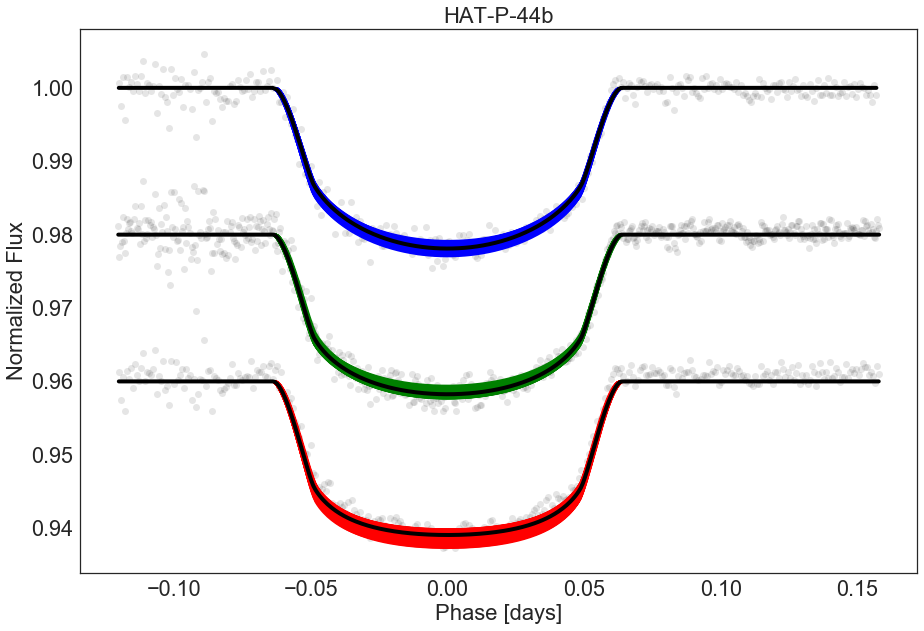

In [61]:
pl.style.use('seaborn-white')
import matplotlib
matplotlib.rcParams.update({'font.size': 18})
pl.rcParams['ytick.labelsize'] = 'large'
pl.rcParams['xtick.labelsize'] = 'large'

colors='b,g,r'.split(',')
tc_hat=pv[3]
fontsize=22
labels=[r'MuSCAT/ $g\prime_2$',r'MuSCAT/ $r\prime_2$',r'MuSCAT/ $z_{s,2}$']

fig,ax=pl.subplots(1,1,figsize=(15,10))
for n,(b,c,l) in enumerate(zip(bands,colors,labels)):
    ax.plot(times[n]-tc_hat, fluxes[n]/sys_best[b]-0.02*n, 'ko', alpha=0.1)
    for i in mod[b]:
        ax.plot(times[n]-tc_hat, i-0.02*n,'-', color=c, label=l)
    #superpose best fit
    ax.plot(times[n]-tc_hat, mod_best[b]-0.02*n, 'k-', lw=4)
    #plt.setp(ax.get_xticklabels(), visible=False)
ax.set_title('HAT-P-44b',fontsize=fontsize)
ax.set_ylabel('Normalized Flux', fontsize=fontsize)
ax.set_xlabel('Phase [days]', fontsize=fontsize)
#ax.legend(labels,loc='lower right',fontsize=fontsize)

In [62]:
fig.savefig('figs/1000_posterior_samples.png')

### systematics model

In [63]:
pv[3]

7800.2200124475485

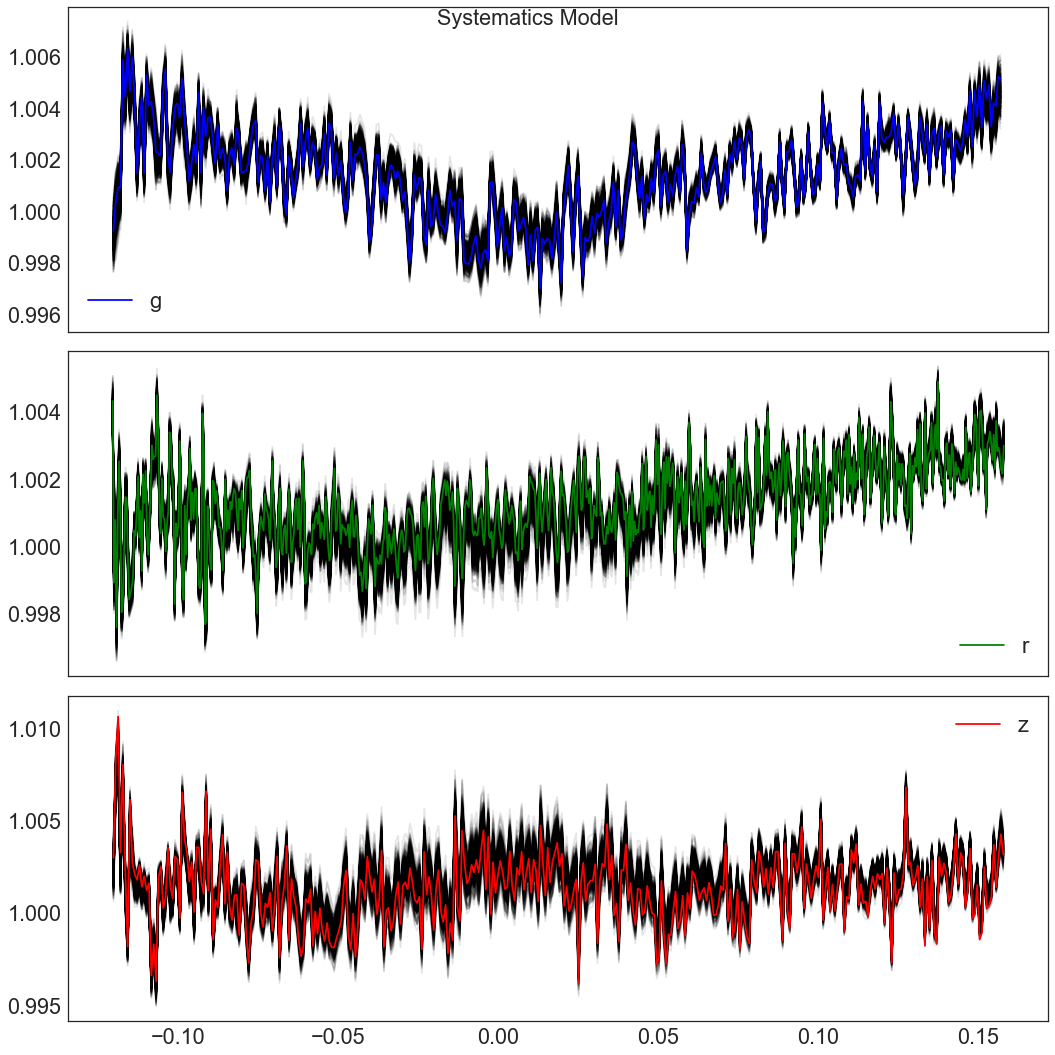

In [78]:
tc_hat=pv[3]
fig,ax = pl.subplots(3,1,figsize=(15,15),sharex=True)

for n,(b,c) in enumerate(zip(bands,colors)):
    for i in sys[b]:
        ax[n].plot(times[n]-tc_hat, i,'k-',alpha=0.1)
    #superpose best fit
    ax[n].plot(times[n]-tc_hat, sys_best[b], '-', color=c, label=b)
    ax[n].legend(fontsize=fontsize, loc='best')
pl.suptitle('Systematics Model')
fig.tight_layout()

In [79]:
fig.savefig('figs/sys.png')

### systematics + transit

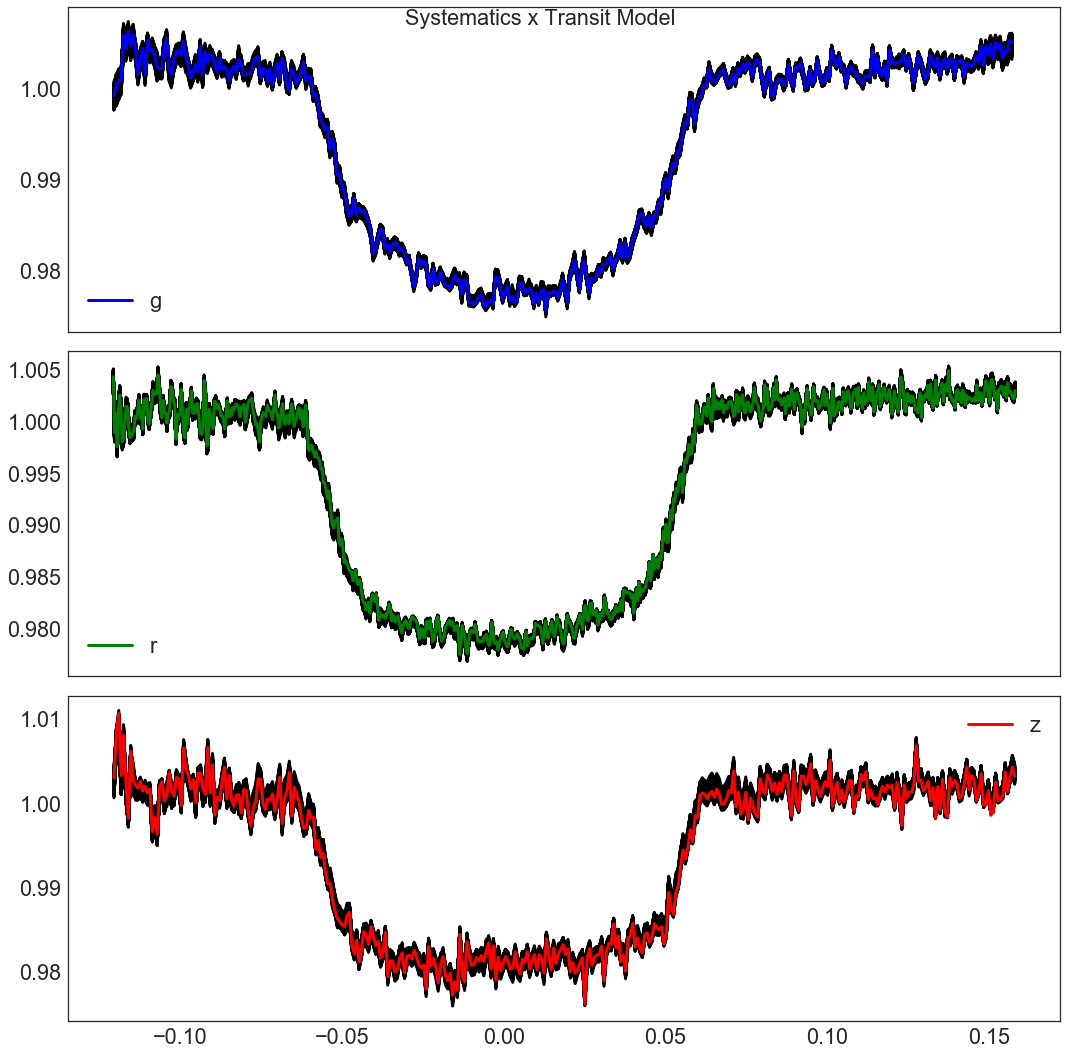

In [91]:
tc_hat=pv[3]
fig,ax = pl.subplots(3,1,figsize=(15,15), sharex=True)
for n,(b,c) in enumerate(zip(bands,colors)):
    for i in mod_sys[b]:
        ax[n].plot(times[n]-tc_hat, i,'k-')
    #superpose best fit
    ax[n].plot(times[n]-tc_hat, full_best[b], '-', color=c, label=b)
    ax[n].legend(fontsize=fontsize, loc='best')
pl.suptitle('Systematics x Transit Model')
fig.tight_layout()

In [92]:
fig.savefig('figs/transit with sys.png',bbox_inches='tight',pad_inches=0.01)

In [93]:
def rms(x):
    return np.sqrt(np.nanmean(x**2))

In [94]:
thinning=10
for n,b in enumerate(bands):
    text=rms(fluxes[n]/sys_best[b]-mod_best[b])*100
    print('{}:\trms={}'.format(b,text))
    logging.info('{}:\trms={}'.format(b,text))

g:	rms=0.13257838495771262
r:	rms=0.1541916050194813
z:	rms=0.14479829241954403


In [95]:
def binned(a, binsize, fun=np.mean):
    a_b = []
    for i in range(0, a.shape[0], binsize):
        a_b.append(fun(a[i:i+binsize], axis=0))
        
    return np.array(a_b)

def binned_rms(residuals, timestep, start_min=5, stop_min=20):
    """
    residuals : flux/sys_model - transit_model
    timestep  : time interval between datapoints in seconds
    """

    assert timestep < start_min * 60
    ndata = len(residuals)

    min_bs = int(start_min * 60 / timestep)
    max_bs = int(stop_min  * 60 / timestep)

    rms_err      = []
    rms_err_dict = {}
    for bs in np.arange(min_bs, max_bs + 1):
        nbins = ndata / bs
                
        #binning       
        rms_val = np.sqrt(np.mean(binned(residuals,bs)**2))
        rms_err.append(rms_val)
        rms_err_dict[bs] = rms_val
        
    return rms_err_dict

In [120]:
rms_binned = {}

exptimes = [60,30,60] #sec

n=0
for b,ts in zip(bands,exptimes):
    resid = (fluxes[n] / sys_best[b] - mod_best[b]).values
    rms_bin = binned_rms(resid, ts, start_min=2, stop_min=20)
    rms_binned[b] = rms_bin
    n+=1

(0, 20)

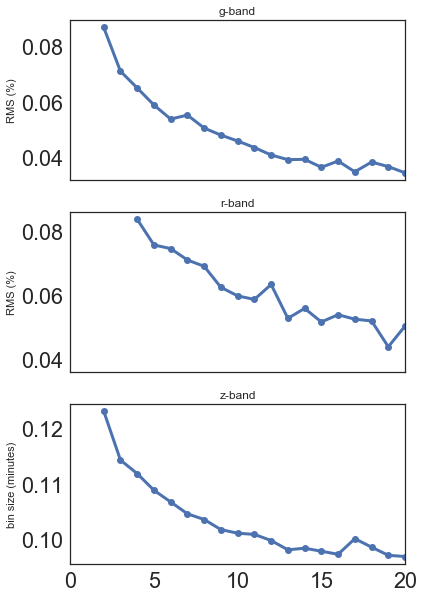

In [122]:
fig,ax=pl.subplots(3,1,figsize=(6,10), sharex=True)
b='g'
n=0
for b in bands:
    ax[n].plot(list(rms_binned[b].keys()),
               np.array(list(rms_binned[b].values()))*100, 'o-')
    ax[n].set_title('{}-band'.format(b))
    ax[n].set_ylabel('RMS (%)')
    #ax[n].set_ylim(-0.001,0.001)
    n+=1
ax[n-1].set_ylabel('bin size (minutes)')
pl.xlim(0,20)

In [123]:
fig.savefig('rms vs binsize.png')

## g-band

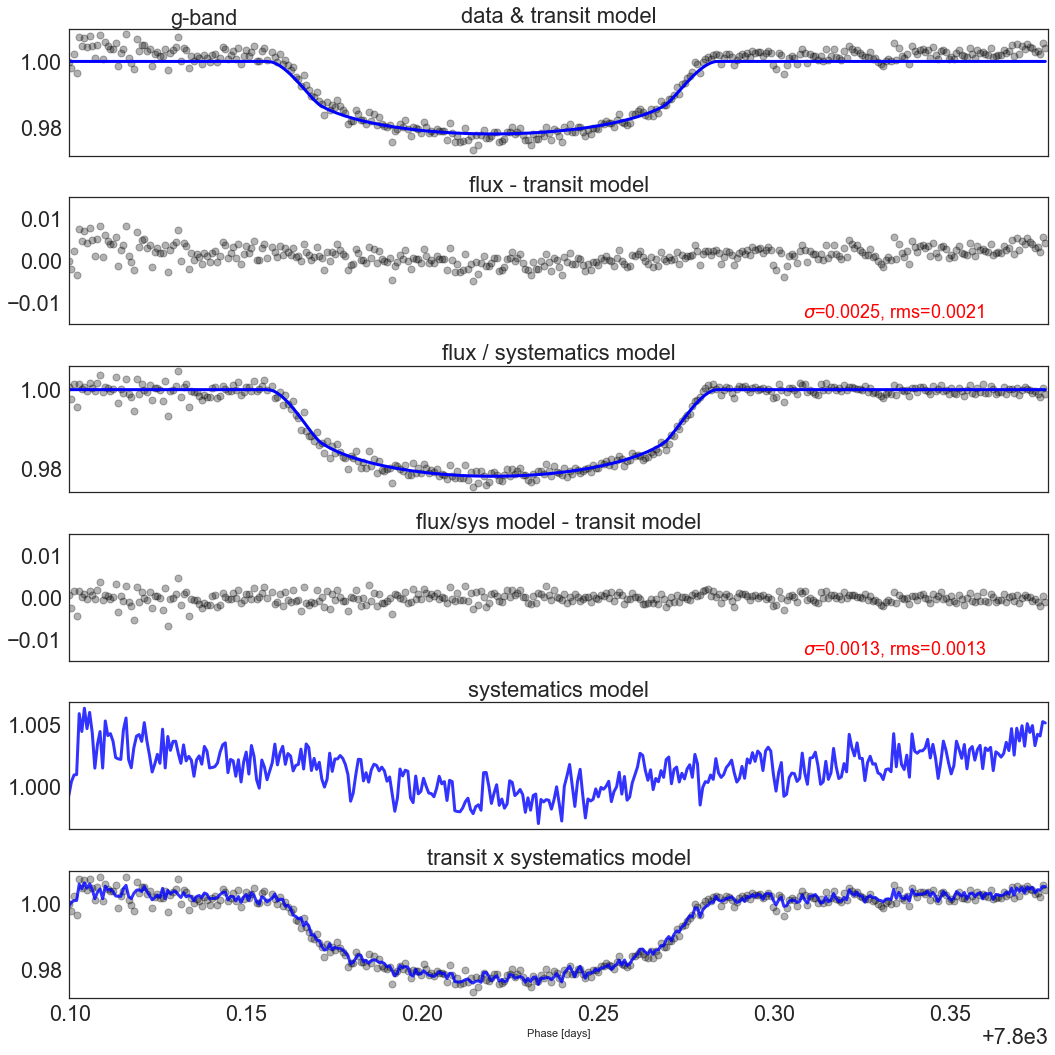

In [128]:
pl.style.use('seaborn-white')
import matplotlib
matplotlib.rcParams.update({'font.size': 18})
pl.rcParams['ytick.labelsize'] = 'large'
pl.rcParams['xtick.labelsize'] = 'large'
pl.rcParams['lines.linewidth'] = 3
n=0
b='g'
xlim=[-0.015,0.015]

pl.style.use('seaborn-white')
fig, ax = pl.subplots(6, 1, figsize=(15,15), sharex=True)
pl.suptitle('{}-band'.format(b),x=0.2)

#uncorrected
ax[0].plot(times[n], fluxes[n], linestyle='none', marker='o',
    color='k', alpha=0.3, mew=1, mec='k');
ax[0].plot(times[n], mod_best[b], 'b-')
ax[0].set_title('data & transit model',fontsize=fontsize)
#residuals
res1=fluxes[n]-mod_best[b]
ax[1].plot(times[n], res1, linestyle='none', marker='o',
    color='k', alpha=0.3, mew=1, mec='k');
#rms
res='$\sigma$={:.4f}, rms={:.4f}'.format(rms(res1),np.std(res1))
ax[1].text(0.75,0.05,res,transform=ax[1].transAxes,color='r')
ax[1].set_title('flux - transit model',fontsize=fontsize)
ax[1].set_ylim(xlim)
#corrected
ax[2].plot(times[n], fluxes[n]/sys_best[b], linestyle='none', marker='o',
    color='k', alpha=0.3, mew=1, mec='k');
ax[2].plot(times[n], mod_best[b], 'b-')
ax[2].set_title('flux / systematics model',fontsize=fontsize)
#residuals
res2=fluxes[n]/sys_best[b]-mod_best[b]
ax[3].plot(times[n], res2, linestyle='none', marker='o',
    color='k', alpha=0.3, mew=1, mec='k');
#rms
res='$\sigma$={:.4f}, rms={:.4f}'.format(rms(res2),np.std(res2))
ax[3].text(0.75,0.05,res,transform=ax[3].transAxes,color='r')
ax[3].set_title('flux/sys model - transit model',fontsize=fontsize)
ax[3].set_ylim(xlim)
#systematics
ax[4].plot(times[n], sys_best[b], 'b-', alpha=0.8)
ax[4].set_title('systematics model',fontsize=fontsize)
ax[5].plot(times[n], fluxes[n], linestyle='none', marker='o',
    color='k', alpha=0.3, mew=1, mec='k');
ax[5].plot(times[n], full_best[b], 'b-', alpha=0.8);
ax[5].set_title('transit x systematics model',fontsize=fontsize)
pl.setp(ax, xlim=(t.min(), t.max()));
#plt.xlabel('Time [MJD]')
pl.xlabel('Phase [days]')
fig.tight_layout()

In [129]:
fig.savefig('figs/summary_g.png')

## r-band

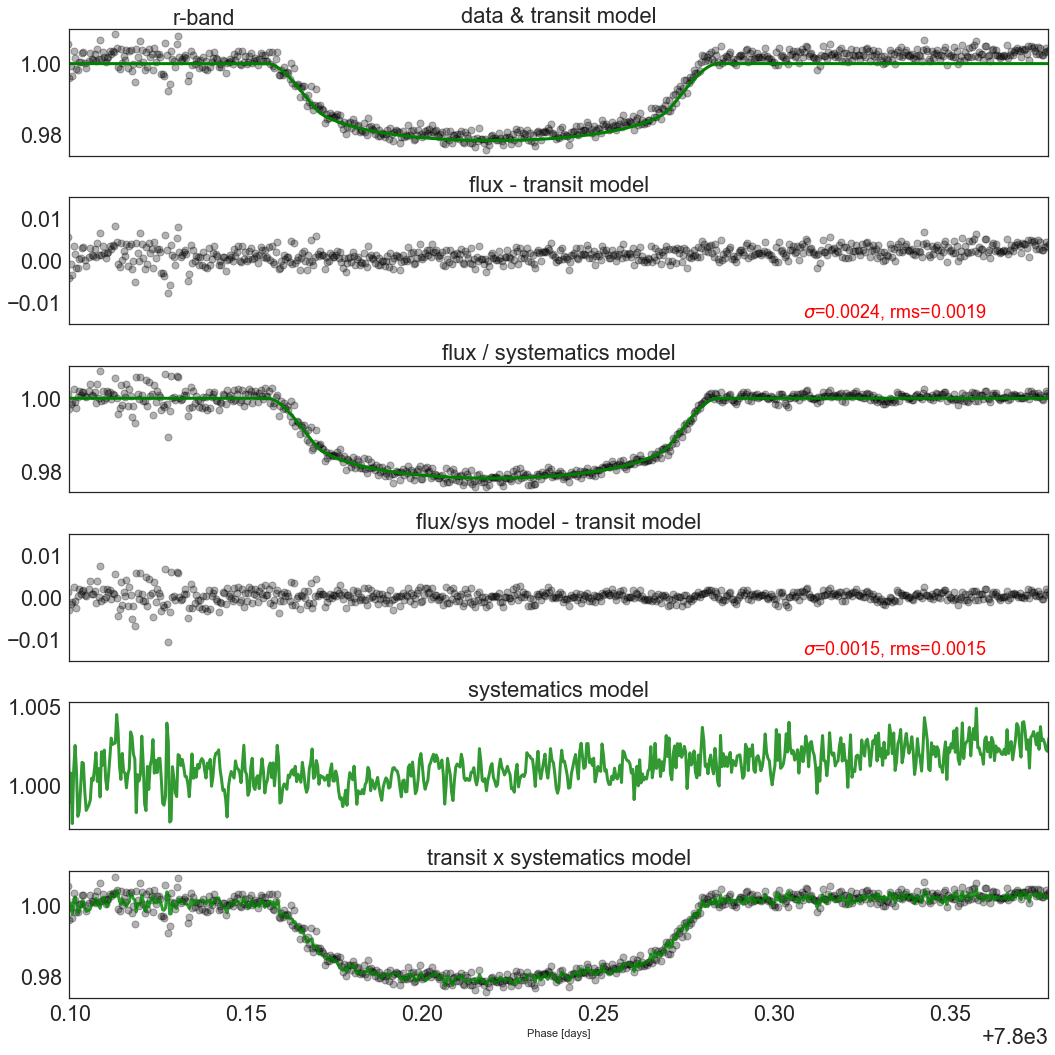

In [126]:
n=1
b='r'
xlim=[-0.015,0.015]

pl.style.use('seaborn-white')
fig, ax = pl.subplots(6, 1, figsize=(15,15), sharex=True)
pl.suptitle('{}-band'.format(b),x=0.2)

#uncorrected
ax[0].plot(times[n], fluxes[n], linestyle='none', marker='o',
    color='k', alpha=0.3, mew=1, mec='k');
ax[0].plot(times[n], mod_best[b], 'g-')
ax[0].set_title('data & transit model',fontsize=fontsize)
#residuals
res1=fluxes[n]-mod_best[b]
ax[1].plot(times[n], res1, linestyle='none', marker='o',
    color='k', alpha=0.3, mew=1, mec='k');
#rms
res='$\sigma$={:.4f}, rms={:.4f}'.format(rms(res1),np.std(res1))
ax[1].text(0.75,0.05,res,transform=ax[1].transAxes,color='r')
ax[1].set_title('flux - transit model',fontsize=fontsize)
ax[1].set_ylim(xlim)
#corrected
ax[2].plot(times[n], fluxes[n]/sys_best[b], linestyle='none', marker='o',
    color='k', alpha=0.3, mew=1, mec='k');
ax[2].plot(times[n], mod_best[b], 'g-')
ax[2].set_title('flux / systematics model',fontsize=fontsize)
#residuals
res2=fluxes[n]/sys_best[b]-mod_best[b]
ax[3].plot(times[n], res2, linestyle='none', marker='o',
    color='k', alpha=0.3, mew=1, mec='k');
#rms
res='$\sigma$={:.4f}, rms={:.4f}'.format(rms(res2),np.std(res2))
ax[3].text(0.75,0.05,res,transform=ax[3].transAxes,color='r')
ax[3].set_title('flux/sys model - transit model',fontsize=fontsize)
ax[3].set_ylim(xlim)
#systematics
ax[4].plot(times[n], sys_best[b], 'g-', alpha=0.8)
ax[4].set_title('systematics model',fontsize=fontsize)
ax[5].plot(times[n], fluxes[n], linestyle='none', marker='o',
    color='k', alpha=0.3, mew=1, mec='k');
ax[5].plot(times[n], full_best[b], 'g-', alpha=0.8);
ax[5].set_title('transit x systematics model',fontsize=fontsize)
pl.setp(ax, xlim=(t.min(), t.max()));
#plt.xlabel('Time [MJD]')
pl.xlabel('Phase [days]')
fig.tight_layout()

In [127]:
fig.savefig('figs/summary_r.png')

## z-band

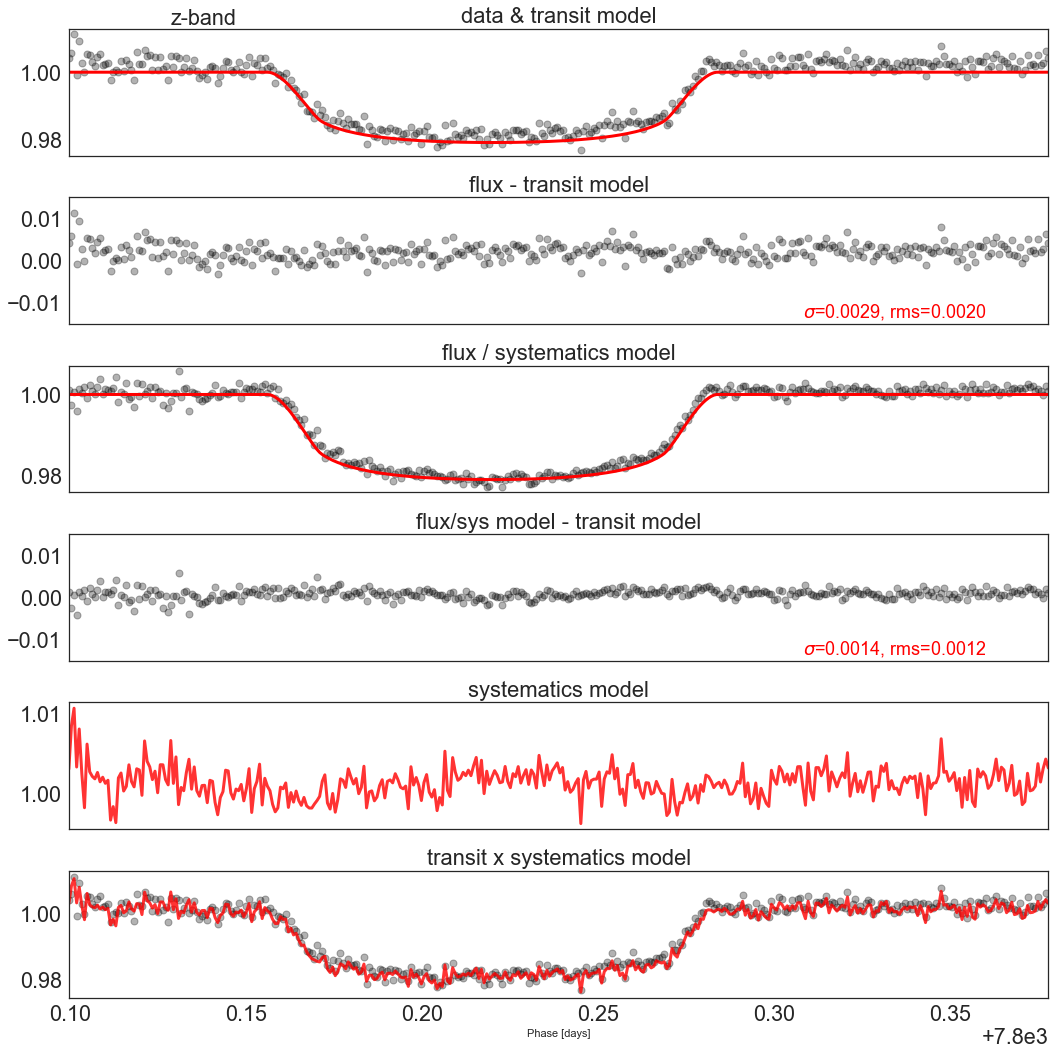

In [124]:
n=2
b='z'
xlim=[-0.015,0.015]

pl.style.use('seaborn-white')
fig, ax = pl.subplots(6, 1, figsize=(15,15), sharex=True)
pl.suptitle('{}-band'.format(b),x=0.2)

#uncorrected
ax[0].plot(times[n], fluxes[n], linestyle='none', marker='o',
    color='k', alpha=0.3, mew=1, mec='k');
ax[0].plot(times[n], mod_best[b], 'r-')
ax[0].set_title('data & transit model',fontsize=fontsize)
#residuals
res1=fluxes[n]-mod_best[b]
ax[1].plot(times[n], res1, linestyle='none', marker='o',
    color='k', alpha=0.3, mew=1, mec='k');
#rms
res='$\sigma$={:.4f}, rms={:.4f}'.format(rms(res1),np.std(res1))
ax[1].text(0.75,0.05,res,transform=ax[1].transAxes,color='r')
ax[1].set_title('flux - transit model',fontsize=fontsize)
ax[1].set_ylim(xlim)
#corrected
ax[2].plot(times[n], fluxes[n]/sys_best[b], linestyle='none', marker='o',
    color='k', alpha=0.3, mew=1, mec='k');
ax[2].plot(times[n], mod_best[b], 'r-')
ax[2].set_title('flux / systematics model',fontsize=fontsize)
#residuals
res2=fluxes[n]/sys_best[b]-mod_best[b]
ax[3].plot(times[n], res2, linestyle='none', marker='o',
    color='k', alpha=0.3, mew=1, mec='k');
#rms
res='$\sigma$={:.4f}, rms={:.4f}'.format(rms(res2),np.std(res2))
ax[3].text(0.75,0.05,res,transform=ax[3].transAxes,color='r')
ax[3].set_title('flux/sys model - transit model',fontsize=fontsize)
ax[3].set_ylim(xlim)
#systematics
ax[4].plot(times[n], sys_best[b], 'r-', alpha=0.8)
ax[4].set_title('systematics model',fontsize=fontsize)
ax[5].plot(times[n], fluxes[n], linestyle='none', marker='o',
    color='k', alpha=0.3, mew=1, mec='k');
ax[5].plot(times[n], full_best[b], 'r-', alpha=0.8);
ax[5].set_title('transit x systematics model',fontsize=fontsize)
pl.setp(ax, xlim=(t.min(), t.max()));
#plt.xlabel('Time [MJD]')
pl.xlabel('Phase [days]')
fig.tight_layout()

In [125]:
fig.savefig('figs/summary_z.png')

## binning
* See [stackoverflow](https://stackoverflow.com/questions/6163334/binning-data-in-python-with-scipy-numpy)

The binning must be less than t14 and/or t34. Based on the best fit model on the detrended light curve, t14 is about 0.01 to 0.02 day.

## binning before model fitting

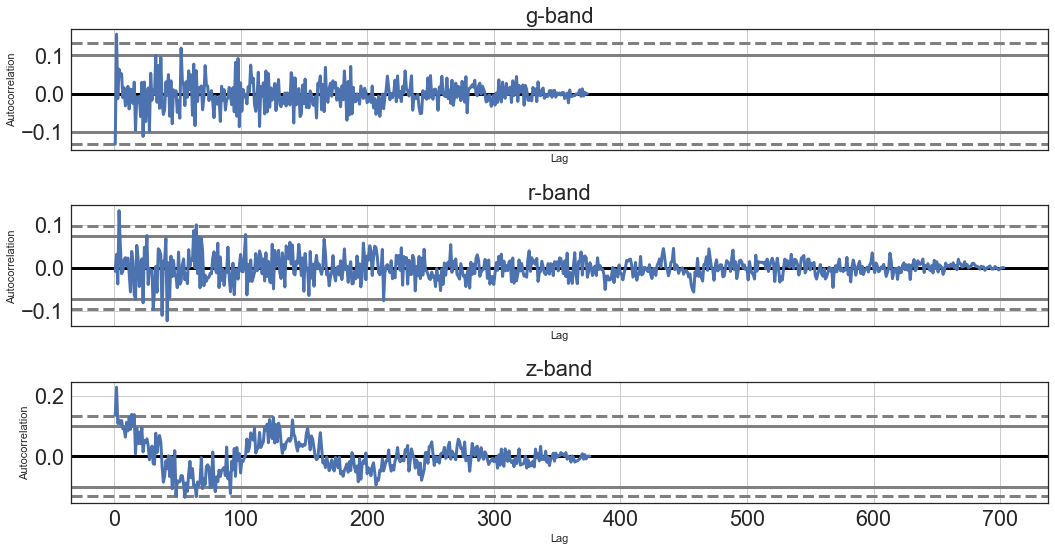

In [132]:
from pandas.plotting import autocorrelation_plot

fig,ax = pl.subplots(3,1, figsize=(15,8), sharex=True)

for n,b in enumerate(bands):
    autocorrelation_plot(fluxes[n]-sys_best[b]-mod_best[b], ax=ax[n])
    ax[n].set_title('{}-band'.format(b),fontsize=fontsize)
    #autocorrelation_plot(sys_best[b]-mod_best[b], ax=ax)
fig.tight_layout()

In [134]:
fig.savefig('figs/autocorrelation.png')

correlation: u1, u2; k1, k3; i, a

In [136]:
n,b=0,'g'
d1 = {'g_flux': fluxes[n], 'g_mod': mod_best[b], 'g_sys':sys_best[b], 'g_full': full_best[b], 'g(f/sys)': fluxes[n]/sys_best[b]}
df1=pd.DataFrame(data=d1, index=times[n])

n,b=1,'r'
d2 = {'r_flux': fluxes[n], 'r_mod': mod_best[b], 'r_sys':sys_best[b], 'r_full': full_best[b], 'r(f/sys)': fluxes[n]/sys_best[b]}
df2=pd.DataFrame(data=d2, index=times[n])

n,b=2,'z'
d3 = {'z_flux': fluxes[n], 'z_mod': mod_best[b], 'z_sys':sys_best[b], 'z_full': full_best[b], 'z(f/sys)': fluxes[n]/sys_best[b]}
df3=pd.DataFrame(data=d3, index=times[n])

frames = [df1, df2, df3]

final_df = pd.concat(frames)
final_df.tail()

g(f/sys)  g_flux  g_full  g_mod  g_sys  r(f/sys)  r_flux  \
BJD(TDB)-2450000                                                             
7800.3748              NaN     NaN     NaN    NaN    NaN       NaN     NaN   
7800.3756              NaN     NaN     NaN    NaN    NaN       NaN     NaN   
7800.3763              NaN     NaN     NaN    NaN    NaN       NaN     NaN   
7800.3771              NaN     NaN     NaN    NaN    NaN       NaN     NaN   
7800.3778              NaN     NaN     NaN    NaN    NaN       NaN     NaN   

                  r_full  r_mod  r_sys  z(f/sys)  z_flux  z_full  z_mod  \
BJD(TDB)-2450000                                                          
7800.3748            NaN    NaN    NaN    1.0013  1.0050  1.0037    1.0   
7800.3756            NaN    NaN    NaN    1.0008  1.0021  1.0014    1.0   
7800.3763            NaN    NaN    NaN    0.9998  1.0028  1.0031    1.0   
7800.3771            NaN    NaN    NaN    1.0021  1.0063  1.0043    1.0   
7800.3778            NaN    NaN    NaN    1.0010  1.0041  1.0031    1.0   

                   z_sys  
BJD(TDB)-2450000          
7800.3748         1.0037  
7800.3756         1.0014  
7800.3763         1.0031  
7800.3771         1.0043  
7800.3778         1.0031

## Save

In [137]:
final_df.to_csv('after_mcmc_hatp44b.csv')

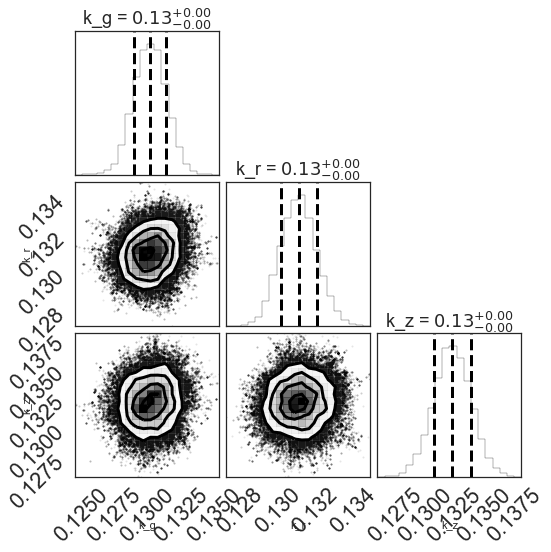

In [138]:
import corner


fig =  corner.corner(fc[:,:3], labels=param_names[:3], 
              quantiles=[0.16, 0.5, 0.84], 
              show_titles=True, title_kwargs={"fontsize": 18});

In [139]:
fig.savefig('figs/joint_k.png')

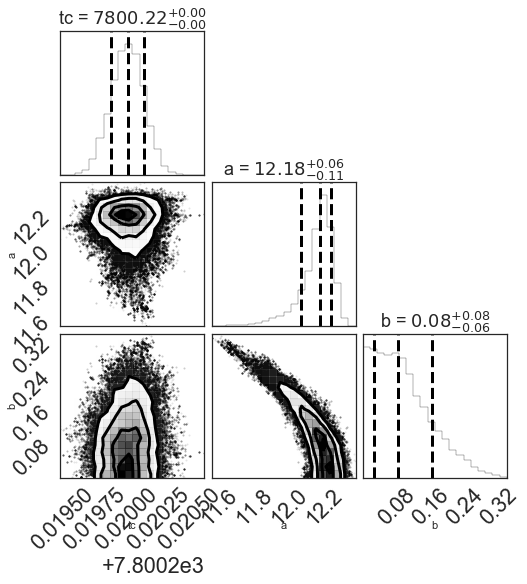

In [142]:
import corner

fig = corner.corner(fc[:,3:6], labels=param_names[3:6], 
              quantiles=[0.16, 0.5, 0.84], 
              show_titles=True, title_kwargs={"fontsize": 18});

In [143]:
fig.savefig('figs/joint_tc_a_b.png')

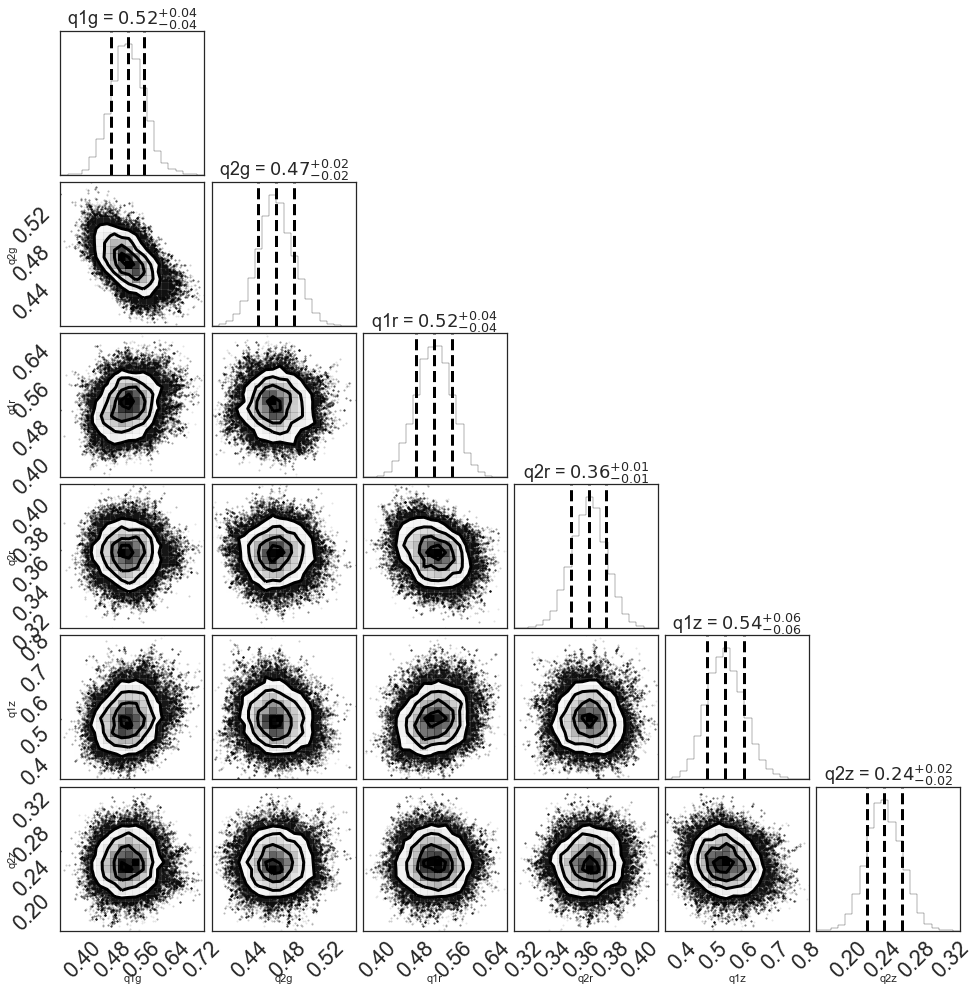

In [146]:
fig = corner.corner(fc[:,6:12], labels=param_names[6:12], 
              quantiles=[0.16, 0.5, 0.84], 
              show_titles=True, title_kwargs={"fontsize": 18});

In [147]:
fig.savefig('figs/limbdark_q1q2.png')

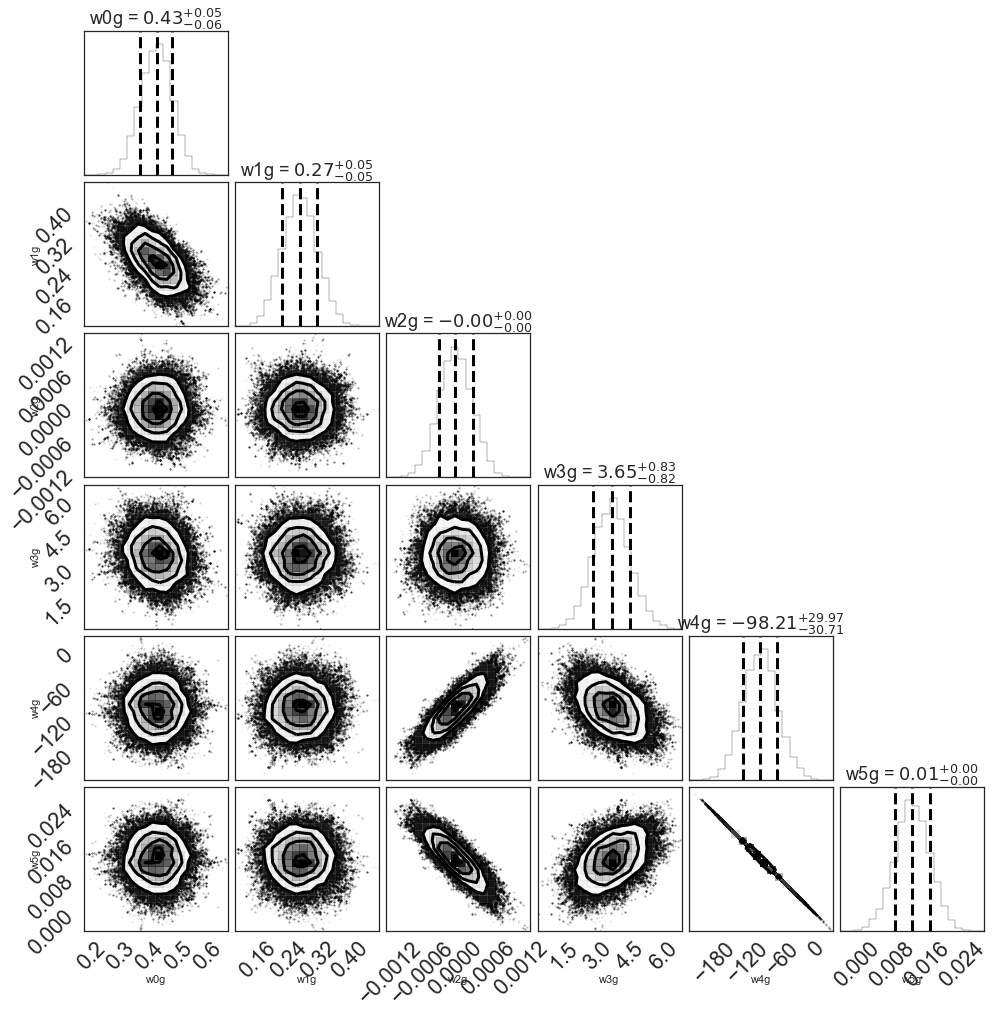

In [150]:
fig = corner.corner(fc[:,12:18], labels=param_names[12:18], 
              quantiles=[0.16, 0.5, 0.84], 
              show_titles=True, title_kwargs={"fontsize": 18});

In [151]:
fig.savefig('figs/joint_sys_g.png')

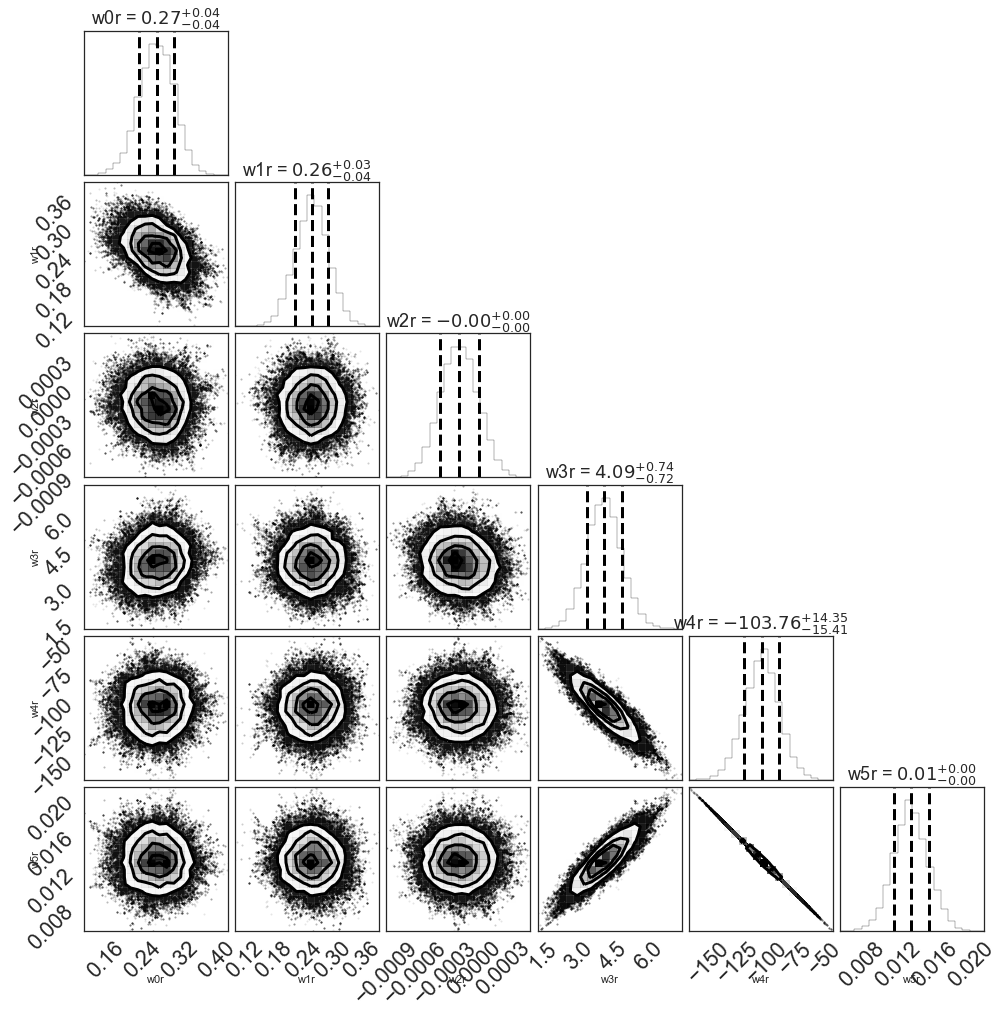

In [152]:
fig = corner.corner(fc[:,18:24], labels=param_names[18:24], 
              quantiles=[0.16, 0.5, 0.84], 
              show_titles=True, title_kwargs={"fontsize": 18});

In [153]:
fig.savefig('figs/joint_sys_r.png.png')

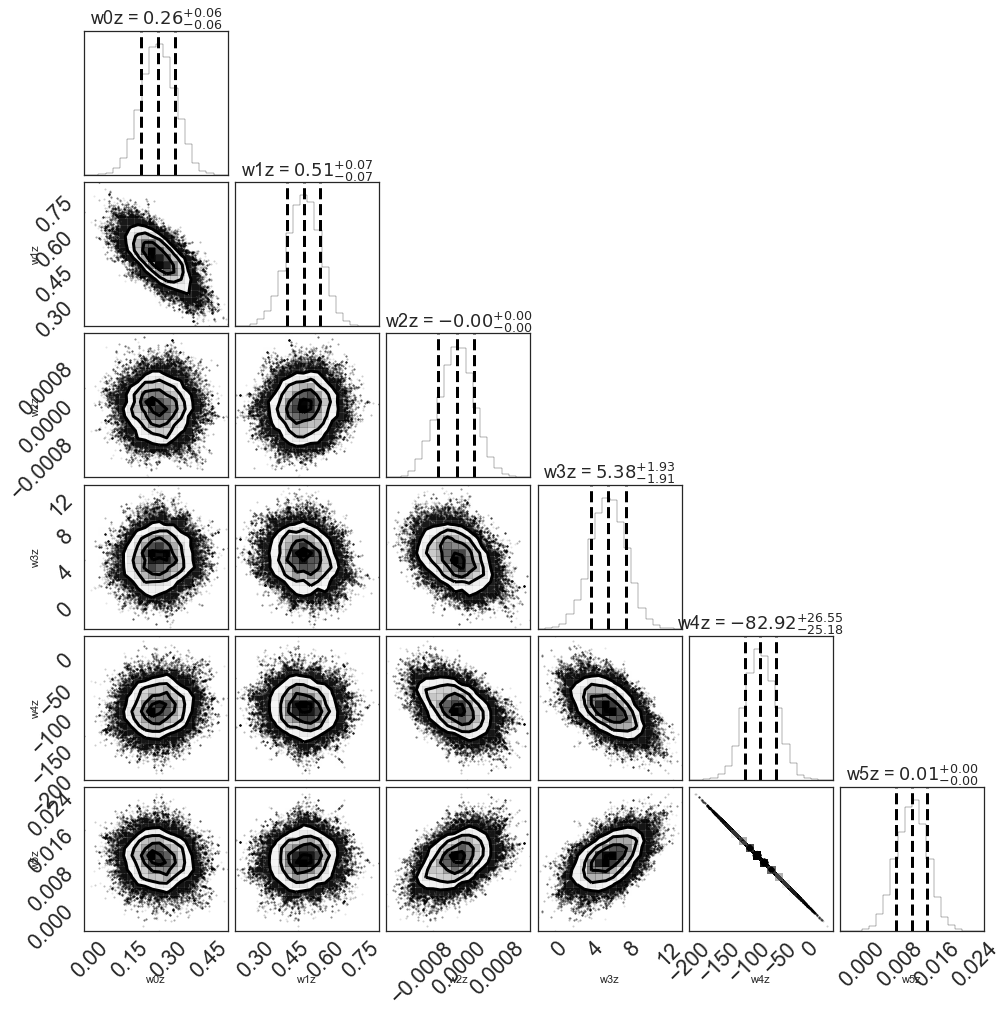

In [154]:
fig = corner.corner(fc[:,24:30], labels=param_names[24:30], 
              quantiles=[0.16, 0.5, 0.84], 
              show_titles=True, title_kwargs={"fontsize": 18});

In [155]:
fig.savefig('figs/joint_sys_z.png.png')

## even sampling of time (index)

Add evenly sampled time to compensate for sparse data (resulting to edgy/not smooth model fits especially in limb-darkening areas.

### Reevaluate model using new evenly-sampled time

## best fit with uncertainties: credible intervals

In [163]:
post=[]
for i,(j,p) in enumerate(zip(pv,param_names)):
    fc_sample=fc[np.random.randint(0, fc.shape[0], size=1000)]
    sig_minus,mean,sig_plus=np.percentile(fc_sample[:,i], [16,50,84], axis=0)
    vals='{0}={1:.4f}\t- {2:.4f} \t+ {2:.4f}'.format(p,j,sig_minus,sig_plus)
    post.append(vals)
    print(vals)
    #print(mean)
np.save('post_with_unc_hapt44b.csv',post)

k_g=0.1288	- 0.1290 	+ 0.1290
k_r=0.1307	- 0.1302 	+ 0.1302
k_z=0.1307	- 0.1309 	+ 0.1309
tc=7800.2200	- 7800.2199 	+ 7800.2199
a=12.1310	- 12.0741 	+ 12.0741
b=0.0868	- 0.0239 	+ 0.0239
q1g=0.5970	- 0.4751 	+ 0.4751
q2g=0.4585	- 0.4503 	+ 0.4503
q1r=0.5867	- 0.4793 	+ 0.4793
q2r=0.3533	- 0.3516 	+ 0.3516
q1z=0.5972	- 0.4796 	+ 0.4796
q2z=0.2213	- 0.2212 	+ 0.2212
w0g=0.4515	- 0.3704 	+ 0.3704
w1g=0.2567	- 0.2240 	+ 0.2240
w2g=-0.0001	- -0.0003 	+ -0.0003
w3g=4.5204	- 2.7601 	+ 2.7601
w4g=-124.3324	- -130.5449 	+ -130.5449
w5g=0.0160	- 0.0088 	+ 0.0088
w0r=0.3091	- 0.2321 	+ 0.2321
w1r=0.2666	- 0.2230 	+ 0.2230
w2r=-0.0003	- -0.0003 	+ -0.0003
w3r=3.4863	- 3.3302 	+ 3.3302
w4r=-82.7407	- -120.2246 	+ -120.2246
w5r=0.0107	- 0.0115 	+ 0.0115
w0z=0.3216	- 0.2001 	+ 0.2001
w1z=0.5414	- 0.4373 	+ 0.4373
w2z=0.0005	- -0.0005 	+ -0.0005
w3z=6.4826	- 3.4813 	+ 3.4813
w4z=-103.9331	- -107.6393 	+ -107.6393
w5z=0.0133	- 0.0073 	+ 0.0073


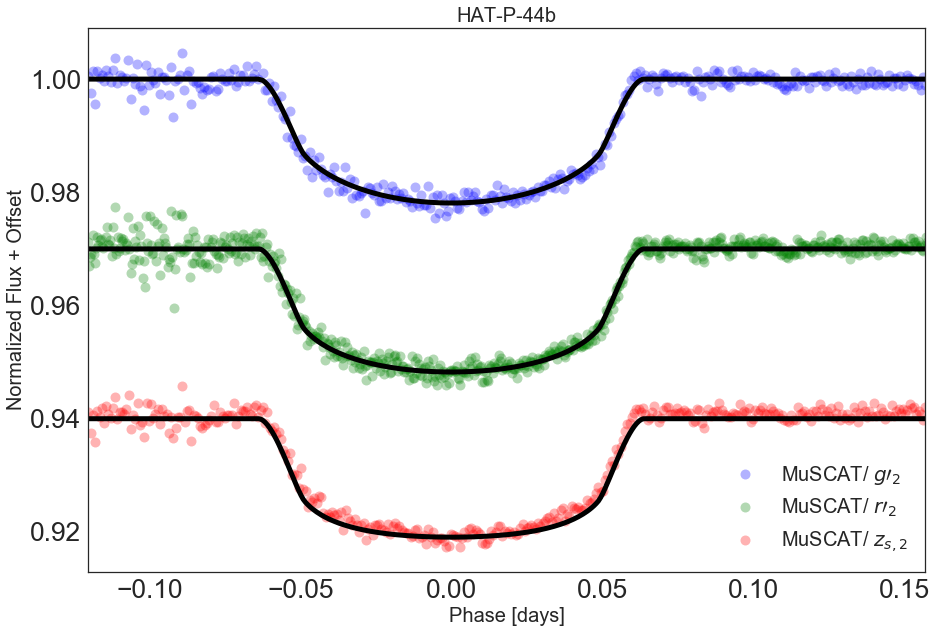

In [165]:
import matplotlib 
# # #matplotlib.rcParams.keys()
matplotlib.rcParams.update({'font.size': 22})
matplotlib.rcParams.update({'lines.linewidth': 5})
pl.rcParams['ytick.labelsize'] = 'large'
pl.rcParams['xtick.labelsize'] = 'large'
fontsize=20

final_df=pd.read_csv('after_mcmc_hatp44b.csv', parse_dates=True, index_col=0)

tc=pv[3]
final_df.index=final_df.index-tc
fig,ax=pl.subplots(1,1,figsize=(15,10))
cols='g(f/sys),r(f/sys),z(f/sys)'.split(',')
colors=['b','g','r']
labels=[r'MuSCAT/ $g\prime_2$',r'MuSCAT/ $r\prime_2$',r'MuSCAT/ $z_{s,2}$']
clipped = 1
offset=0.03
for i,(col,c,l) in enumerate(zip(cols,colors,labels)):
    final_df.iloc[:-clipped][col].apply(lambda x : x-offset*i).plot(
                marker='.', ms=20,
                alpha=0.3, linestyle='', linewidth=100,color=c, ax=ax,
                label=l)

cols2='g_mod,r_mod,z_mod'.split(',')
for i,(col,c) in enumerate(zip(cols2,colors)):
    final_df.iloc[:-clipped][col].apply(lambda x : x-offset*i).plot(ax=ax, 
                                                    linewidth=5, color='k')
    
ax.set_xlabel('Phase [days]', fontsize=fontsize)
ax.set_ylabel('Normalized Flux + Offset', fontsize=fontsize)
#ax.set_ylim(0.8,1)
ax.set_title('HAT-P-44b', fontsize=fontsize)
ax.legend(labels,loc='best', fontsize=fontsize)

In [166]:
fig.savefig('figs/grz.png')

## Best fit models and (binned) residuals
* binning3 function is not implemented because of NaNs; df.resample is better because it takes into account the actual time and not only the separation between data points (e.g. two consecutive data points might be NaN and it can be problematic after binning). 
* See `width` to check binning width in min

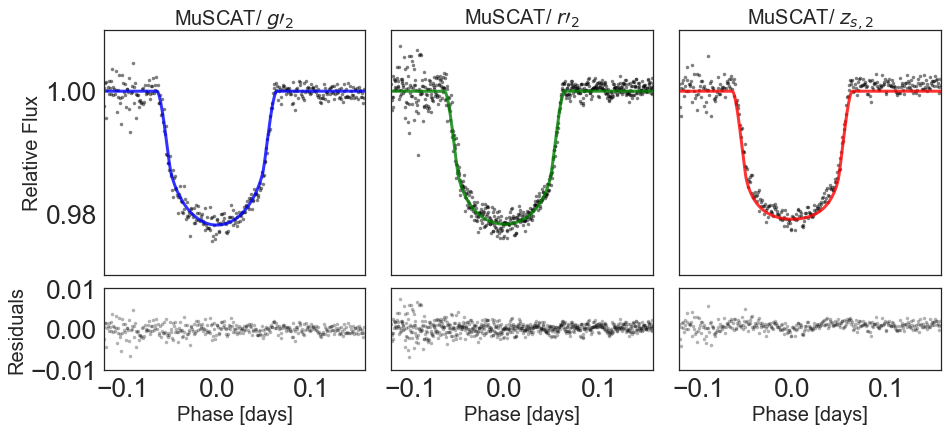

In [170]:
matplotlib.rcParams.update({'font.size': 22})
matplotlib.rcParams.update({'lines.linewidth': 3})
from scipy import stats

final_df=pd.read_csv('after_mcmc_hatp44b.csv', parse_dates=True, index_col=0)
#final_df = df.set_index(pd.to_datetime(df.index, unit='D', origin=offset))

from matplotlib import gridspec

fig = pl.figure(figsize=(15,8))

gs = gridspec.GridSpec(3, 3,
                       width_ratios=[1, 1, 1],
                       height_ratios=[3, 1, 1],
                       wspace=0.1, 
                       hspace=0.1
                       )
clip=False
binn=False
clipped=20
binning='3T'
ylims= [0.97,1.01]
ylims2= [-0.01,0.01]

tc=pv[3]
final_df.index=final_df.index-tc

ax1 = pl.subplot(gs[0])
if clip==True:
    final_df.iloc[:-clipped]['g(f/sys)'].plot(marker='.',alpha=0.5, 
                                            linestyle='', color='k', ax=ax1)
elif binn==True:
    final_df['g(f/sys)'].resample(binning).mean().plot(marker='.', 
                                alpha=0.1, linestyle='-', color=colors[0], ax=ax1)
else:
    final_df['g(f/sys)'].plot(marker='.', 
                                alpha=0.5, linestyle='', color='k', ax=ax1)
final_df['g_mod'].plot(linestyle='-',alpha=0.8, color=colors[0], ax=ax1)

ax1.set_ylim(ylims)
ax1.set_title(r'MuSCAT/ $g\prime_2$',fontsize=fontsize)
ax1.set_xticklabels([])
ax1.set_ylabel('Relative Flux',fontsize=fontsize)
ax1.set_xlabel('')

ax2 = pl.subplot(gs[1])

if clip==True:
    final_df.iloc[:-clipped]['r(f/sys)'].plot(
        marker='.', alpha=0.5, linestyle='-', color=colors[1], ax=ax2)
elif binn==True:
    final_df['r(f/sys)'].resample(binning).mean().plot(
        marker='.', alpha=0.1, linestyle='-', color=colors[1], ax=ax2)
else:
    final_df['r(f/sys)'].plot(marker='.',alpha=0.5, linestyle='', color='k', ax=ax2)
final_df['r_mod'].plot(alpha=0.8, linestyle='-', color=colors[1], ax=ax2)

ax2.set_ylim(ylims)
ax2.set_title(r'MuSCAT/ $r\prime_2$',fontsize=fontsize)
#ax2.axis()
ax2.set_xticklabels([])
ax2.set_yticklabels([])
ax2.set_xlabel('')

ax3 = pl.subplot(gs[2])

if clip==True: #dropna, clip
    final_df.iloc[:-clipped]['z(f/sys)'].plot(
        marker='.', alpha=0.5, linestyle='-', color=colors[2], ax=ax3)
elif binn==True: #bin
    final_df['z(f/sys)'].resample(binning).mean().plot(
        marker='.', ls='', alpha=0.1, linestyle='-', color=colors[2], ax=ax3)
else:
    final_df['z(f/sys)'].plot(marker='.',alpha=0.5, linestyle='', color='k', ax=ax3)
final_df['z_mod'].plot(linestyle='-', alpha=0.8, color=colors[2], ax=ax3)
    
ax3.set_ylim(ylims)
ax3.set_title(r'MuSCAT/ $z_{s,2}$',fontsize=fontsize)
ax3.set_xticklabels([])
ax3.set_xlabel('')
ax3.set_yticklabels([])

ax4 = pl.subplot(gs[3])
diff_g=final_df['g(f/sys)']-final_df['g_mod']
diff_g.plot(marker='.', ls='', color='k', alpha=0.3, ax=ax4)
#diff_g.resample(binning).mean().plot(marker='.', ax=ax4)

# t_bin=binning3(ts[0],bins=n_min_binning['g'])
# res_bin=binning3(diff_g.values,bins=n_min_binning['g'])
# ax4.plot(t_bin,res_bin,'bo')
ax4.set_ylabel('Residuals',fontsize=fontsize)
ax4.set_ylim(ylims2)
#ax4.set_xticklabels([])
ax4.set_xlabel('Phase [days]',fontsize=fontsize)

ax5 = pl.subplot(gs[4])
diff_r=final_df['r(f/sys)']-final_df['r_mod']
diff_r.plot(marker='.', ls='', color='k', alpha=0.3, ax=ax5)
#diff_r.resample(binning).mean().plot(marker='.', ax=ax5)

# t_bin=binning3(ts[1],bins=n_min_binning['r'])
# res_bin=binning3(diff_r.values,bins=n_min_binning['r'])
# ax5.plot(t_bin,res_bin,'go')
ax5.set_ylim(ylims2)
#ax5.set_xticklabels([])
ax5.set_yticklabels([])
ax5.set_xlabel('Phase [days]',fontsize=fontsize)

ax6 = pl.subplot(gs[5])
diff_z=final_df['z(f/sys)']-final_df['z_mod']
diff_z.plot(marker='.', ls='', color='k', alpha=0.3, ax=ax6)
#fit
slope, intercept, r_value, p_value, std_err = stats.linregress(diff_z.index-tc,diff_z)
y=slope*diff_z.index-tc+intercept
ax6.plot(diff_z.index,y,alpha=0.8, linestyle='-', color=colors[2])
#diff_z.resample(binning).mean().plot(marker='.', ax=ax6)

# t_bin=binning3(ts[2],bins=n_min_binning['z'])
# res_bin=binning3(diff_z.values,bins=n_min_binning['z'])
# ax6.plot(t_bin,res_bin,'bo')
ax6.set_ylim(ylims2)
#ax6.set_xticklabels([])
ax6.set_yticklabels([])
ax6.set_xlabel('Phase [days]',fontsize=fontsize)

In [171]:
fig.savefig('figs/grz with rms.png')

## Comparison of k

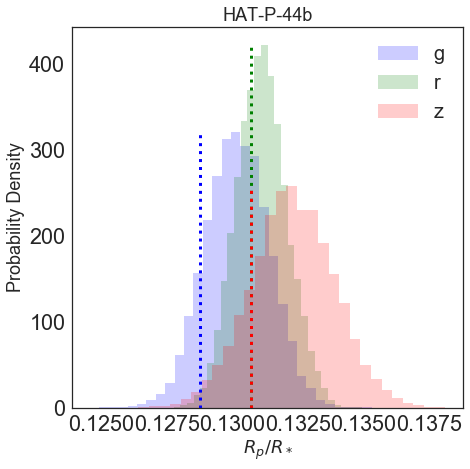

In [177]:
pl.style.use('seaborn-white')
import matplotlib
matplotlib.rcParams.update({'font.size': 18})
pl.rcParams['ytick.labelsize'] = 'large'
pl.rcParams['xtick.labelsize'] = 'large'

k_samples=[]

fig, ax = pl.subplots(1,1,figsize=(7,7))
labels='g,r,z'.split(',')
colors=['b','g','r']

thin=1
for n,(c,l) in enumerate(zip(colors,labels)):
    sampled=fc[::thin,n]
    arr,bins,_=ax.hist(sampled,bins=30,color=c,histtype='stepfilled',
                       label=l,alpha=0.2,normed=True);
    #show aposteriori value
    #ymin,ymax = ax.get_ylim()
    ymin,ymax = 0,np.max(arr)
    ax.vlines(pv[n], ymin,ymax, linestyles='dotted', color=c)# ,label='map')
    
    k_samples.append(sampled)
    ax.legend()
    ax.set_xlabel(r'$R_p/R_*$',fontsize=18)
    #ax.set_xticklabels(rotation=45)
    ax.set_ylabel('Probability Density',fontsize=18)
    ax.set_title('HAT-P-44b',fontsize=18)
pl.legend(fontsize=fontsize)

In [178]:
fig.savefig('figs/radius ratios.png')

In [179]:
np.mean(pv[:3])

0.13006613747216256

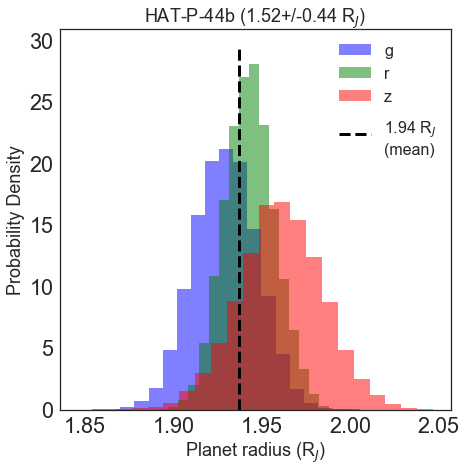

In [181]:
from astropy import units as u

import matplotlib
matplotlib.rcParams.update({'font.size': 18})
pl.rcParams['ytick.labelsize'] = 'large'
pl.rcParams['xtick.labelsize'] = 'large'
fontsize = 18

Rs = ufloat(0.949,0.08) #+0.08/-0.037
Rs = Rp.nominal_value #*u.Rsun.to(u.Rjup) #± 0.04

k_samples=[]

fig, ax = pl.subplots(1,1,figsize=(7,7))
labels='g,r,z'.split(',')
colors=['b','g','r']

thin=1
for n,(c,l) in enumerate(zip(colors,labels)):
    sampled=fc[::thin,n]
    factor=Rs*u.Rsun.to(u.Rjup)
    ax.hist(sampled*factor,bins=20,color=c,histtype='stepfilled',alpha=0.5,label=l,normed=True);
    #ax.hist(sampled,bins=20,color=c,histtype='stepfilled',alpha=0.5,label=l,normed=True);
    #ax.set_xlabel(r'$R_p/R_*$',fontsize=18)
    k_samples.append(sampled)
    ax.legend()
    ax.set_xlabel(r'Planet radius (R$_J$)',fontsize=fontsize)
    ax.set_ylabel('Probability Density',fontsize=fontsize)
#show mean of aposteriori values
mean=np.mean(pv[n]*factor)
pl.vlines(mean, *ax.get_ylim(), 
          linestyles='dashed', color='k', label='{:.2f} R$_J$\n(mean)'.format(mean))
pl.title('HAT-P-44b ({:.2f} R$_J$)'.format(Rp),fontsize=fontsize)
pl.legend(loc='best', fontsize=16)

In [182]:
Rp_ = np.mean(pv[:3])*factor
print('published value = {}\ncomputed \t= {}\ndifference\t= {}'.format(Rp,Rp_,Rp - Rp_))

published value = 1.5+/-0.4
computed 	= 1.9276523111870008
difference	= -0.4+/-0.4


In [183]:
fig.savefig('figs/radius ratios Rjup.png')

In [184]:
sigma_g_minus,sigma_g_mean,sigma_g_plus= np.percentile(k_samples[0],[15.9,50,84.1])
sigma_z_minus,sigma_z_mean,sigma_z_plus= np.percentile(k_samples[2],[15.9,50,84.1])
#diff=sigma_g_mean-sigma_z_mean
diff=sigma_g_minus-sigma_z_plus

sig=np.sqrt(sigma_z_plus**2+sigma_g_minus**2)
print('sigma_rss={}'.format(sig))
print('diff={}'.format(diff))
print('sigma={}'.format(diff/sig))

sigma_rss=0.1859060124138196
diff=-0.0049058092673714415
sigma=-0.026388653081597487


In units of Jupiter radius

## transmission spectrum

* See also procedure of [Nikolov+2016](https://arxiv.org/pdf/1610.01186.pdf)

In [185]:
for n in range(3):
    print(np.percentile(fc[::10,n],[50,16,84]))

[ 0.13018638  0.12898355  0.1313899 ]
[ 0.13110911  0.13015511  0.13206793]
[ 0.13229323  0.13075013  0.13388225]


In [186]:
pv[:3]

array([ 0.12876946,  0.13071131,  0.13071764])

* blue (g'2 : 400-550nm)
* red (r'2 : 550-700nm)
* NIR (zs,2 : 820-920nm)
* rp/rs=0.1343 (i-band)

slope=0.000005


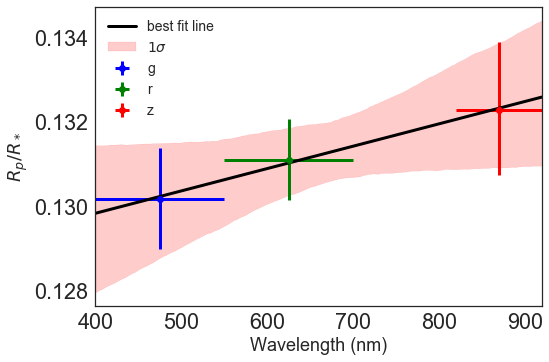

In [187]:
from scipy.stats import linregress as lg
pl.style.use('seaborn-white')

thin = 1

#bandwidths
xs1=[400,550,820]
xs2=[550,700,920]
#mean of each band
xmean=np.mean([xs1,xs2],axis=0)
ys=[]

#plot max aposteriori
fig,ax=pl.subplots(1,1)
for n,(x,c) in enumerate(zip(xmean,colors)):
    y,yerr1,yerr2=np.percentile(fc[::10,n],[50,16,84],axis=0)
    ys.append(y)
    
#fit a line to k1,k2,k3
slope,intercept,rvalue,pvalue,stderr=lg(xmean,ys)
wavelengths=np.arange(400,1e3,1)
#ax.plot(wavelengths,slope*np.array(wavelengths)+intercept, 'k-')

#sample and fit slopes and intercepts from the posterior
nsamples = 10000
x = xmean
xi = np.linspace(400, 920, 500)
ys = []
lines = []
bands='g,r,z'.split(',')

for i in range(nsamples):
    y = fc[i,:3]
    slope,intercept,rvalue,pvalue,stderr = lg(xmean,y)
    line = slope * xi + intercept
    lines.append(line)
    
lo, hi, mid = np.percentile(lines, [16, 84, 50], axis=0)
ax.fill_between(xi, lo, hi, color='r', alpha=0.2, label='$1\sigma$')

#FIXME: not a line (curvy)!
#ax.plot(xi,mid,'k-',label='best fit line')

'''
#best fit line of the map of each k
ax.plot(xmean,pv[:3],'ko') #data points
slope,intercept,rvalue,pvalue,stderr = lg(xmean,pv[:3])
ax.plot(xi,xi*slope+intercept,'k-',label='best fit line')
'''
#plot error bar
new_axis=[]
for n,(x,c,b) in enumerate(zip(xmean,colors,bands)):
    yerr1,yerr2,y = np.percentile(fc[::thin,n],[16,84,50])
    ys.append(y)
    #asymmetric
    yerr=np.array([y-yerr1, yerr2-y]).reshape(2,-1)
    #symmetric
    xerr=(xmean-xs1)[n]
    ax.errorbar(x,y,yerr = yerr, xerr=xerr, fmt='o',color=c, label=b) 
    new_axis.append(y*Rs)

#best fit line of the map of each k samples
slope,intercept,rvalue,pvalue,stderr = lg(xmean,ys)
ax.plot(xi,xi*slope+intercept,'k-',label='best fit line')

ax.set_xlabel('Wavelength (nm)',fontsize=fontsize)
ax.set_ylabel(r'$R_p/R_*$',fontsize=fontsize)
ax.set_xlim(400,920)
ax.legend(fontsize=14)

print('slope={:.6f}'.format(slope))

In [188]:
fig.savefig('figs/spectrum.png')

## significance of detection

In [189]:
slopes=[]
intercepts=[]
nsamples=1000

s1=k_samples[0][np.random.randint(0, k_samples[0].shape[0], size=nsamples)]
s2=k_samples[1][np.random.randint(0, k_samples[1].shape[0], size=nsamples)]
s3=k_samples[2][np.random.randint(0, k_samples[2].shape[0], size=nsamples)]

for ss1,ss2,ss3 in zip(s1,s2,s3): 
    slope,intercept,_,_,_=lg(xmean,[ss1,ss2,ss3])
    slopes.append(slope)
    intercepts.append(intercept)

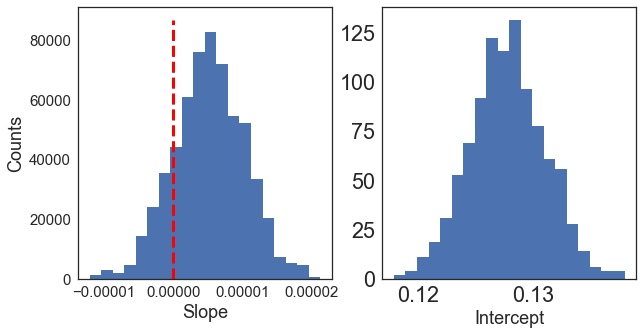

In [190]:
fig,ax=pl.subplots(1,2,figsize=(10,5))
ax[0].hist(slopes,bins=20,normed=True);
ax[0].vlines(0, *ax[0].get_ylim(), color='r', linestyle='dashed')
ax[0].set_ylabel('Counts',fontsize=fontsize)
ax[0].set_xlabel('Slope',fontsize=fontsize)
ax[0].tick_params(axis='both', which='major', labelsize=15)
ax[1].hist(intercepts,bins=20,normed=True);
ax[1].set_xlabel('Intercept',fontsize=fontsize)

In [191]:
fig.savefig('figs/slope.png')

From the posterior distribution of radius ratios, we took 1000 random samples each and computed the slope of the transmission spectrum (positioned at the center of the broadband filters). The histogram of the slope is shown in Fig. X consistent with negative values with 2.3 sigma.

In [192]:
x1,x2,x3=np.percentile(slopes,[50,15.9,84.1])
sig_plus=x3-x1
print((0-x1)/sig_plus)

-1.00093761839
